# Association Analysis of Filipino Cuisine Ingredients


## Data loading and preview


### Read JSON files


In [1]:
import json
import os


def load_recipes(path="data/recipes"):
    """Combines all recipe data into a single list."""
    files = [file for file in os.listdir(path)]

    recipes = []
    for file in files:
        file_path = os.path.join(path, file)
        with open(file_path, encoding="utf-8") as f:
            recipe_data = json.load(f)
            recipes.extend(recipe_data)

    return recipes


recipes = load_recipes()
recipes[0]

{'link': 'https://www.allrecipes.com/recipe/128699/famous-chicken-adobo/',
 'name': 'Famous Chicken Adobo',
 'ingredients': ['2 tablespoons vegetable oil',
  '1 (3 pound) chicken, cut into pieces',
  '1 large onion, quartered and sliced',
  '2 tablespoons minced garlic',
  ' 2/3  cup low sodium soy sauce',
  ' 1/3  cup white vinegar',
  '1 tablespoon garlic powder',
  '2 teaspoons black pepper',
  '1  bay leaf'],
 'instructions': ['Step 1: Heat vegetable oil in a large skillet over medium-high heat. Cook chicken pieces until golden brown, 2 to 3 minutes per side. Transfer chicken to a plate and set aside.',
  'Step 2: Add onion and garlic to the skillet; cook until softened and brown, about 6 minutes.',
  'Step 3: Pour in soy sauce and vinegar and season with garlic powder, black pepper, and bay leaf.',
  'Step 4: Return chicken to pan, increase heat to high, and bring to a boil. Reduce heat to medium-low, cover, and simmer until chicken is tender and cooked through, 35 to 40 minutes.'

### Convert JSON to DataFrame


In [2]:
import pandas as pd


recipe_df = pd.DataFrame(recipes)
recipe_df.head()

,link,name,ingredients,instructions
0,https://www.allrecipes.com/recipe/128699/famou...,Famous Chicken Adobo,"[2 tablespoons vegetable oil, 1 (3 pound) chic...",[Step 1: Heat vegetable oil in a large skillet...
1,https://www.allrecipes.com/recipe/212994/pinak...,Pinakbet,"[3 tablespoons olive oil, 1 onion, chopped, 2...",[Step 1: Heat oil in a large pot over medium h...
2,https://www.allrecipes.com/recipe/204958/pork-...,Pork Sinigang,"[1 tablespoon vegetable oil, 1 small onion, ch...",[Step 1: Heat vegetable oil in a skillet over ...
3,https://www.allrecipes.com/recipe/270708/lumpi...,Lumpia in the Air Fryer,"[1 pound Italian hot sausage links, 1/2 cup f...",[Step 1: Remove casing from sausage and cook i...
4,https://www.allrecipes.com/recipe/212911/filip...,Filipino Beef Steak,"[4 pounds New York strip steak, sliced thin, 1...",[Step 1: Place sliced beef in a large bowl. Wh...


In [3]:
recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4244 entries, 0 to 4243
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   link          4244 non-null   object
 1   name          3898 non-null   object
 2   ingredients   3896 non-null   object
 3   instructions  3872 non-null   object
dtypes: object(4)
memory usage: 132.8+ KB


### Display some statistics


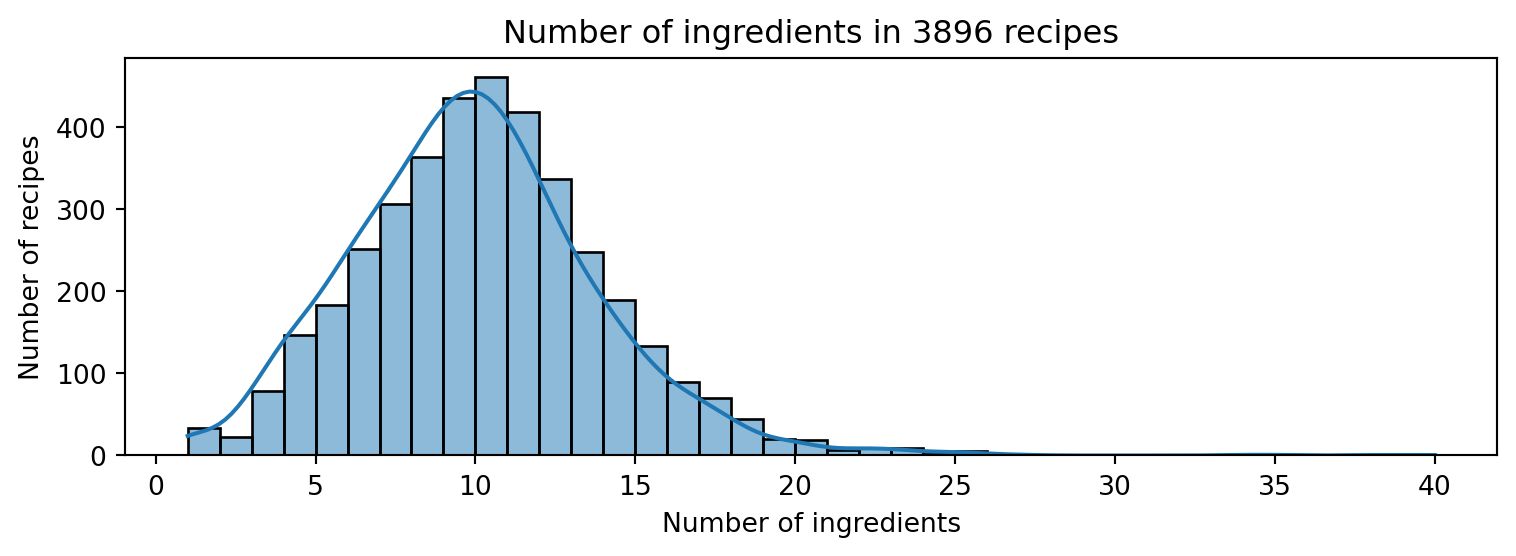

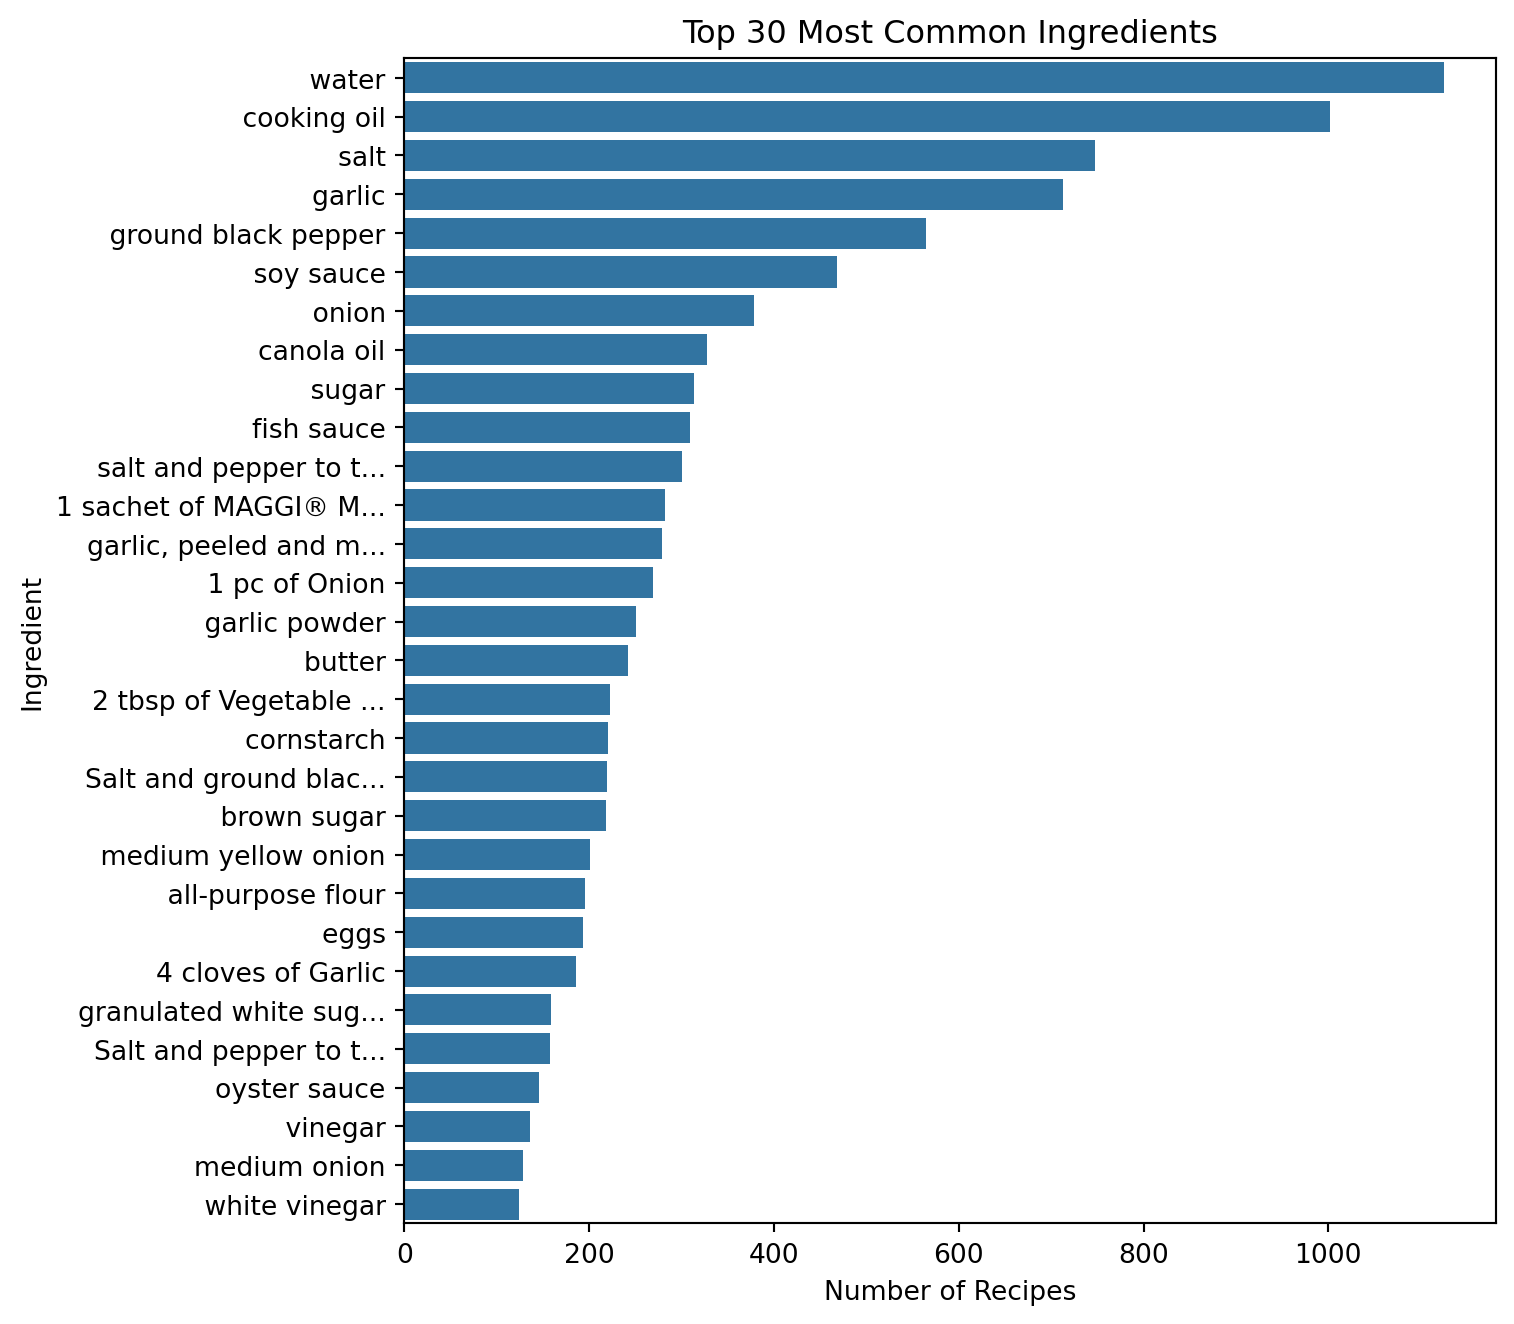

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns


def plot_ingredient_count_distribution(ingredient_series, figsize=(8, 3)):
    """Plots the distribution of the number of ingredients in recipes."""
    counts = ingredient_series.dropna().apply(len)
    plt.figure(figsize=figsize)
    sns.histplot(counts, kde=True, binwidth=1)
    plt.title(f"Number of ingredients in {len(counts)} recipes")
    plt.xlabel("Number of ingredients")
    plt.ylabel("Number of recipes")
    plt.tight_layout()
    plt.show()


def plot_common_ingredients(
    ingredient_series, n=30, most_common=True, figsize=(8, 7)
):
    """Plots the most or least common ingredients."""
    all_ingredients = ingredient_series.dropna().explode()
    ingredient_counts = all_ingredients.value_counts()

    if most_common:
        top_n_ingredients = ingredient_counts.head(n)
    else:
        top_n_ingredients = ingredient_counts.tail(n)

    ylabels = [
        f"{i[:20]:>20}{'...' if len(i) > 20 else ''}"
        for i in top_n_ingredients.index
    ]
    plt.figure(figsize=figsize)
    sns.barplot(x=top_n_ingredients.values, y=ylabels)
    indicator = "Most" if most_common else "Least"
    plt.title(f"Top {n} {indicator} Common Ingredients")
    plt.xlabel("Number of Recipes")
    plt.ylabel("Ingredient")
    plt.tight_layout()
    plt.show()


plot_ingredient_count_distribution(recipe_df.ingredients)
plot_common_ingredients(recipe_df.ingredients, n=30, most_common=True)

## Preprocessing


### Step 0. Remove recipes with no ingredients


In [5]:
def drop_empty_ingredients(recipe_df, column="ingredients"):
    """Drops rows with empty ingredients."""
    new_df = recipe_df.dropna(subset=[column])
    print(f"Dropped {recipe_df.shape[0] - new_df.shape[0]} rows.")
    return new_df


recipe_df = drop_empty_ingredients(recipe_df)

Dropped 348 rows.


In [6]:
def save_ingredients(ingredient_series, path):
    """Saves the ingredients to a TXT file."""
    os.makedirs(os.path.dirname(path), exist_ok=True)

    all_ingredients = ingredient_series.dropna().explode()
    data = sorted(all_ingredients.unique().astype(str))

    with open(path, "w", encoding="utf-8") as file:
        for ingredient in data:
            file.write(f"{ingredient.strip()}\n")


save_ingredients(
    recipe_df.ingredients,
    path="data/preprocess_output/0_raw.txt",
)

### Step 1. Clean ingredient format


In [7]:
import re

from tqdm import tqdm

tqdm.pandas()


def remove_parentheses(ingredient):
    """Removes parentheses and content from ingredient strings."""
    return re.sub(r" ?\([^)]+\)", "", ingredient)


def select_first_option(ingredient):
    """Selects the first option in a string with multiple options."""
    return ingredient.split(" or ")[0]


def clean_ingredient(ingredient):
    """Cleans an ingredient string."""
    ingredient = remove_parentheses(ingredient)
    ingredient = select_first_option(ingredient)
    return ingredient.lower().strip()


recipe_df["cleaned"] = recipe_df.ingredients.progress_apply(
    lambda x: [cleaned for i in x if (cleaned := clean_ingredient(i))]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 58295.58it/s]

In [8]:
save_ingredients(
    recipe_df.cleaned,
    path="data/preprocess_output/1_cleaned.txt",
)

### Step 2. Lemmatize words and remove non-ingredient words


In [9]:
import spacy

nlp = spacy.load("en_core_web_lg")


def correct_noun_pos_tags(token):
    """Corrects the POS tags of specific tokens."""
    outliers = ["cauliflower", "baking"]
    if token.text in outliers:
        token.pos_ = "NOUN"
    return token


def lemmatize_nouns(ingredient):
    """Lemmatizes nouns in an ingredient string."""
    doc = nlp(ingredient)
    lemmas = []
    for token in doc:
        token = correct_noun_pos_tags(token)
        if (
            token.is_alpha
            and not token.is_stop
            and token.pos_ in ["NOUN", "PROPN"]
        ):
            lemmas.append(token.lemma_)
    return " ".join(lemmas)


recipe_df["lemmatized"] = recipe_df.cleaned.progress_apply(
    lambda x: [lemmatized for i in x if (lemmatized := lemmatize_nouns(i))]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

  0%|          | 4/3896 [00:00<02:11, 29.71it/s]

  0%|          | 7/3896 [00:00<02:13, 29.16it/s]

  0%|          | 11/3896 [00:00<02:02, 31.76it/s]

  0%|          | 15/3896 [00:00<02:13, 29.11it/s]

  0%|          | 18/3896 [00:00<02:26, 26.54it/s]

  1%|          | 21/3896 [00:00<02:34, 25.07it/s]

  1%|          | 25/3896 [00:00<02:21, 27.38it/s]

  1%|          | 29/3896 [00:01<02:17, 28.06it/s]

  1%|          | 32/3896 [00:01<02:30, 25.65it/s]

  1%|          | 35/3896 [00:01<02:34, 25.05it/s]

  1%|          | 38/3896 [00:01<02:35, 24.81it/s]

  1%|          | 41/3896 [00:01<02:29, 25.84it/s]

  1%|          | 44/3896 [00:01<02:27, 26.12it/s]

  1%|          | 47/3896 [00:01<02:32, 25.29it/s]

  1%|▏         | 51/3896 [00:01<02:20, 27.30it/s]

  1%|▏         | 54/3896 [00:02<02:17, 27.88it/s]

  1%|▏         | 58/3896 [00:02<02:11, 29.16it/s]

  2%|▏         | 61/3896 [00:02<02:23, 26.79it/s]

  2%|▏         | 64/3896 [00:02<02:25, 26.37it/s]

  2%|▏         | 67/3896 [00:02<02:25, 26.34it/s]

  2%|▏         | 70/3896 [00:02<02:44, 23.27it/s]

  2%|▏         | 73/3896 [00:02<02:42, 23.59it/s]

  2%|▏         | 76/3896 [00:02<02:32, 25.02it/s]

  2%|▏         | 80/3896 [00:02<02:13, 28.49it/s]

  2%|▏         | 84/3896 [00:03<02:11, 28.91it/s]

  2%|▏         | 87/3896 [00:03<02:11, 29.05it/s]

  2%|▏         | 91/3896 [00:03<02:08, 29.64it/s]

  2%|▏         | 94/3896 [00:03<02:20, 27.00it/s]

  3%|▎         | 98/3896 [00:03<02:12, 28.74it/s]

  3%|▎         | 101/3896 [00:03<02:32, 24.85it/s]

  3%|▎         | 104/3896 [00:03<02:37, 24.05it/s]

  3%|▎         | 107/3896 [00:04<02:30, 25.22it/s]

  3%|▎         | 110/3896 [00:04<02:29, 25.38it/s]

  3%|▎         | 113/3896 [00:04<02:23, 26.33it/s]

  3%|▎         | 116/3896 [00:04<02:27, 25.63it/s]

  3%|▎         | 120/3896 [00:04<02:21, 26.69it/s]

  3%|▎         | 123/3896 [00:04<02:22, 26.49it/s]

  3%|▎         | 127/3896 [00:04<02:17, 27.47it/s]

  3%|▎         | 130/3896 [00:04<02:27, 25.59it/s]

  3%|▎         | 133/3896 [00:05<02:35, 24.21it/s]

  3%|▎         | 136/3896 [00:05<02:29, 25.21it/s]

  4%|▎         | 139/3896 [00:05<02:31, 24.84it/s]

  4%|▎         | 142/3896 [00:05<02:28, 25.26it/s]

  4%|▍         | 147/3896 [00:05<02:09, 28.85it/s]

  4%|▍         | 151/3896 [00:05<02:18, 27.11it/s]

  4%|▍         | 154/3896 [00:05<02:15, 27.55it/s]

  4%|▍         | 158/3896 [00:05<02:06, 29.59it/s]

  4%|▍         | 162/3896 [00:06<02:00, 30.87it/s]

  4%|▍         | 166/3896 [00:06<02:05, 29.64it/s]

  4%|▍         | 169/3896 [00:06<02:06, 29.39it/s]

  4%|▍         | 172/3896 [00:06<02:10, 28.50it/s]

  4%|▍         | 175/3896 [00:06<02:09, 28.78it/s]

  5%|▍         | 178/3896 [00:06<02:09, 28.70it/s]

  5%|▍         | 181/3896 [00:06<02:25, 25.61it/s]

  5%|▍         | 184/3896 [00:06<02:20, 26.49it/s]

  5%|▍         | 188/3896 [00:06<02:11, 28.24it/s]

  5%|▍         | 192/3896 [00:07<02:18, 26.71it/s]

  5%|▌         | 195/3896 [00:07<02:15, 27.24it/s]

  5%|▌         | 198/3896 [00:07<02:13, 27.80it/s]

  5%|▌         | 203/3896 [00:07<01:50, 33.42it/s]

  5%|▌         | 207/3896 [00:07<01:46, 34.69it/s]

  5%|▌         | 213/3896 [00:07<01:31, 40.14it/s]

  6%|▌         | 218/3896 [00:07<01:52, 32.70it/s]

  6%|▌         | 222/3896 [00:08<02:00, 30.42it/s]

  6%|▌         | 226/3896 [00:08<02:13, 27.42it/s]

  6%|▌         | 230/3896 [00:08<02:05, 29.18it/s]

  6%|▌         | 236/3896 [00:08<01:42, 35.75it/s]

  6%|▌         | 240/3896 [00:08<01:52, 32.58it/s]

  6%|▋         | 244/3896 [00:08<01:47, 33.91it/s]

  6%|▋         | 248/3896 [00:08<01:55, 31.53it/s]

  6%|▋         | 252/3896 [00:09<02:08, 28.32it/s]

  7%|▋         | 256/3896 [00:09<02:01, 29.91it/s]

  7%|▋         | 260/3896 [00:09<02:10, 27.95it/s]

  7%|▋         | 263/3896 [00:09<02:17, 26.46it/s]

  7%|▋         | 268/3896 [00:09<01:55, 31.44it/s]

  7%|▋         | 273/3896 [00:09<01:44, 34.64it/s]

  7%|▋         | 277/3896 [00:09<01:50, 32.85it/s]

  7%|▋         | 281/3896 [00:09<01:48, 33.39it/s]

  7%|▋         | 285/3896 [00:10<01:44, 34.52it/s]

  7%|▋         | 289/3896 [00:10<01:52, 32.07it/s]

  8%|▊         | 294/3896 [00:10<01:43, 34.68it/s]

  8%|▊         | 299/3896 [00:10<01:38, 36.43it/s]

  8%|▊         | 303/3896 [00:10<01:37, 36.91it/s]

  8%|▊         | 307/3896 [00:10<01:36, 37.11it/s]

  8%|▊         | 311/3896 [00:10<01:46, 33.67it/s]

  8%|▊         | 315/3896 [00:10<01:53, 31.59it/s]

  8%|▊         | 319/3896 [00:11<01:52, 31.75it/s]

  8%|▊         | 323/3896 [00:11<01:54, 31.09it/s]

  8%|▊         | 327/3896 [00:11<01:53, 31.56it/s]

  8%|▊         | 331/3896 [00:11<02:05, 28.40it/s]

  9%|▊         | 334/3896 [00:11<02:08, 27.83it/s]

  9%|▊         | 339/3896 [00:11<01:51, 32.00it/s]

  9%|▉         | 343/3896 [00:11<01:45, 33.68it/s]

  9%|▉         | 347/3896 [00:11<01:40, 35.28it/s]

  9%|▉         | 351/3896 [00:12<01:43, 34.41it/s]

  9%|▉         | 356/3896 [00:12<01:41, 34.87it/s]

  9%|▉         | 360/3896 [00:12<01:46, 33.19it/s]

  9%|▉         | 364/3896 [00:12<01:48, 32.55it/s]

  9%|▉         | 368/3896 [00:12<01:51, 31.62it/s]

 10%|▉         | 372/3896 [00:12<01:45, 33.38it/s]

 10%|▉         | 376/3896 [00:12<01:44, 33.82it/s]

 10%|▉         | 380/3896 [00:12<01:51, 31.58it/s]

 10%|▉         | 384/3896 [00:13<01:50, 31.67it/s]

 10%|▉         | 388/3896 [00:13<01:44, 33.63it/s]

 10%|█         | 392/3896 [00:13<01:52, 31.12it/s]

 10%|█         | 396/3896 [00:13<02:10, 26.89it/s]

 10%|█         | 399/3896 [00:13<02:18, 25.22it/s]

 10%|█         | 402/3896 [00:13<02:16, 25.59it/s]

 10%|█         | 405/3896 [00:13<02:19, 25.07it/s]

 10%|█         | 408/3896 [00:14<02:19, 25.09it/s]

 11%|█         | 411/3896 [00:14<02:18, 25.23it/s]

 11%|█         | 416/3896 [00:14<01:51, 31.12it/s]

 11%|█         | 420/3896 [00:14<01:44, 33.11it/s]

 11%|█         | 425/3896 [00:14<01:35, 36.51it/s]

 11%|█         | 429/3896 [00:14<01:47, 32.35it/s]

 11%|█         | 433/3896 [00:14<02:00, 28.66it/s]

 11%|█         | 437/3896 [00:14<01:56, 29.70it/s]

 11%|█▏        | 441/3896 [00:15<01:55, 29.92it/s]

 11%|█▏        | 445/3896 [00:15<01:50, 31.23it/s]

 12%|█▏        | 450/3896 [00:15<01:43, 33.42it/s]

 12%|█▏        | 454/3896 [00:15<01:42, 33.67it/s]

 12%|█▏        | 458/3896 [00:15<01:45, 32.54it/s]

 12%|█▏        | 462/3896 [00:15<01:41, 33.79it/s]

 12%|█▏        | 467/3896 [00:15<01:38, 34.90it/s]

 12%|█▏        | 471/3896 [00:15<01:43, 33.18it/s]

 12%|█▏        | 475/3896 [00:16<01:42, 33.50it/s]

 12%|█▏        | 479/3896 [00:16<01:47, 31.88it/s]

 12%|█▏        | 484/3896 [00:16<01:38, 34.71it/s]

 13%|█▎        | 488/3896 [00:16<01:38, 34.71it/s]

 13%|█▎        | 494/3896 [00:16<01:30, 37.78it/s]

 13%|█▎        | 499/3896 [00:16<01:28, 38.29it/s]

 13%|█▎        | 503/3896 [00:16<01:40, 33.86it/s]

 13%|█▎        | 507/3896 [00:16<01:39, 34.15it/s]

 13%|█▎        | 511/3896 [00:17<02:06, 26.66it/s]

 13%|█▎        | 514/3896 [00:17<02:13, 25.43it/s]

 13%|█▎        | 518/3896 [00:17<02:02, 27.61it/s]

 13%|█▎        | 521/3896 [00:17<02:04, 27.05it/s]

 13%|█▎        | 525/3896 [00:17<01:53, 29.73it/s]

 14%|█▎        | 529/3896 [00:17<01:53, 29.62it/s]

 14%|█▎        | 533/3896 [00:17<01:52, 29.92it/s]

 14%|█▍        | 537/3896 [00:18<01:50, 30.40it/s]

 14%|█▍        | 541/3896 [00:18<01:51, 30.17it/s]

 14%|█▍        | 545/3896 [00:18<01:46, 31.44it/s]

 14%|█▍        | 549/3896 [00:18<01:56, 28.71it/s]

 14%|█▍        | 552/3896 [00:18<01:56, 28.59it/s]

 14%|█▍        | 556/3896 [00:18<01:52, 29.57it/s]

 14%|█▍        | 559/3896 [00:18<01:54, 29.16it/s]

 14%|█▍        | 564/3896 [00:18<01:42, 32.43it/s]

 15%|█▍        | 568/3896 [00:19<01:40, 33.20it/s]

 15%|█▍        | 572/3896 [00:19<01:40, 33.04it/s]

 15%|█▍        | 576/3896 [00:19<01:36, 34.23it/s]

 15%|█▍        | 580/3896 [00:19<01:34, 35.24it/s]

 15%|█▍        | 584/3896 [00:19<01:41, 32.64it/s]

 15%|█▌        | 588/3896 [00:19<01:50, 29.99it/s]

 15%|█▌        | 592/3896 [00:19<01:45, 31.38it/s]

 15%|█▌        | 596/3896 [00:19<01:46, 30.93it/s]

 15%|█▌        | 601/3896 [00:20<01:40, 32.90it/s]

 16%|█▌        | 605/3896 [00:20<01:40, 32.69it/s]

 16%|█▌        | 609/3896 [00:20<01:51, 29.59it/s]

 16%|█▌        | 614/3896 [00:20<01:46, 30.86it/s]

 16%|█▌        | 619/3896 [00:20<01:36, 33.93it/s]

 16%|█▌        | 623/3896 [00:20<01:38, 33.21it/s]

 16%|█▌        | 628/3896 [00:20<01:29, 36.37it/s]

 16%|█▋        | 634/3896 [00:20<01:22, 39.43it/s]

 16%|█▋        | 638/3896 [00:21<01:23, 38.86it/s]

 16%|█▋        | 642/3896 [00:21<01:30, 36.00it/s]

 17%|█▋        | 646/3896 [00:21<01:31, 35.59it/s]

 17%|█▋        | 650/3896 [00:21<01:34, 34.34it/s]

 17%|█▋        | 655/3896 [00:21<01:28, 36.69it/s]

 17%|█▋        | 659/3896 [00:21<01:36, 33.54it/s]

 17%|█▋        | 663/3896 [00:21<01:42, 31.65it/s]

 17%|█▋        | 667/3896 [00:21<01:42, 31.62it/s]

 17%|█▋        | 671/3896 [00:22<01:48, 29.62it/s]

 17%|█▋        | 675/3896 [00:22<01:58, 27.07it/s]

 17%|█▋        | 679/3896 [00:22<01:53, 28.27it/s]

 18%|█▊        | 682/3896 [00:22<01:58, 27.07it/s]

 18%|█▊        | 685/3896 [00:22<02:05, 25.56it/s]

 18%|█▊        | 689/3896 [00:22<02:00, 26.63it/s]

 18%|█▊        | 694/3896 [00:22<01:48, 29.64it/s]

 18%|█▊        | 699/3896 [00:23<01:37, 32.64it/s]

 18%|█▊        | 703/3896 [00:23<01:40, 31.73it/s]

 18%|█▊        | 708/3896 [00:23<01:32, 34.58it/s]

 18%|█▊        | 712/3896 [00:23<01:34, 33.65it/s]

 18%|█▊        | 717/3896 [00:23<01:27, 36.43it/s]

 19%|█▊        | 721/3896 [00:23<01:32, 34.39it/s]

 19%|█▊        | 725/3896 [00:23<01:39, 31.89it/s]

 19%|█▊        | 729/3896 [00:24<01:39, 31.93it/s]

 19%|█▉        | 733/3896 [00:24<01:33, 33.66it/s]

 19%|█▉        | 737/3896 [00:24<01:39, 31.63it/s]

 19%|█▉        | 741/3896 [00:24<01:42, 30.75it/s]

 19%|█▉        | 745/3896 [00:24<01:43, 30.37it/s]

 19%|█▉        | 749/3896 [00:24<01:37, 32.28it/s]

 19%|█▉        | 753/3896 [00:24<01:37, 32.10it/s]

 19%|█▉        | 757/3896 [00:24<01:43, 30.38it/s]

 20%|█▉        | 761/3896 [00:25<01:36, 32.45it/s]

 20%|█▉        | 765/3896 [00:25<01:32, 33.93it/s]

 20%|█▉        | 769/3896 [00:25<01:41, 30.82it/s]

 20%|█▉        | 773/3896 [00:25<01:40, 30.96it/s]

 20%|█▉        | 777/3896 [00:25<01:37, 31.93it/s]

 20%|██        | 781/3896 [00:25<02:02, 25.50it/s]

 20%|██        | 784/3896 [00:25<02:03, 25.19it/s]

 20%|██        | 787/3896 [00:25<01:58, 26.20it/s]

 20%|██        | 790/3896 [00:26<01:57, 26.47it/s]

 20%|██        | 794/3896 [00:26<01:56, 26.62it/s]

 20%|██        | 797/3896 [00:26<02:04, 24.85it/s]

 21%|██        | 800/3896 [00:26<02:01, 25.53it/s]

 21%|██        | 804/3896 [00:26<01:52, 27.38it/s]

 21%|██        | 807/3896 [00:26<01:52, 27.49it/s]

 21%|██        | 811/3896 [00:26<01:46, 28.88it/s]

 21%|██        | 814/3896 [00:26<01:49, 28.05it/s]

 21%|██        | 817/3896 [00:27<01:49, 28.24it/s]

 21%|██        | 820/3896 [00:27<01:51, 27.63it/s]

 21%|██        | 824/3896 [00:27<01:45, 29.23it/s]

 21%|██        | 827/3896 [00:27<01:48, 28.39it/s]

 21%|██▏       | 830/3896 [00:27<01:46, 28.69it/s]

 21%|██▏       | 833/3896 [00:27<01:50, 27.80it/s]

 21%|██▏       | 836/3896 [00:27<01:49, 27.98it/s]

 22%|██▏       | 839/3896 [00:27<01:56, 26.27it/s]

 22%|██▏       | 842/3896 [00:28<02:01, 25.14it/s]

 22%|██▏       | 845/3896 [00:28<02:00, 25.34it/s]

 22%|██▏       | 849/3896 [00:28<01:46, 28.69it/s]

 22%|██▏       | 853/3896 [00:28<01:35, 31.74it/s]

 22%|██▏       | 857/3896 [00:28<01:51, 27.35it/s]

 22%|██▏       | 860/3896 [00:28<01:52, 27.00it/s]

 22%|██▏       | 863/3896 [00:28<01:49, 27.58it/s]

 22%|██▏       | 866/3896 [00:28<01:50, 27.31it/s]

 22%|██▏       | 870/3896 [00:28<01:45, 28.64it/s]

 22%|██▏       | 874/3896 [00:29<01:39, 30.42it/s]

 23%|██▎       | 878/3896 [00:29<01:45, 28.53it/s]

 23%|██▎       | 881/3896 [00:29<01:45, 28.64it/s]

 23%|██▎       | 884/3896 [00:29<01:49, 27.61it/s]

 23%|██▎       | 887/3896 [00:29<01:53, 26.60it/s]

 23%|██▎       | 891/3896 [00:29<01:42, 29.25it/s]

 23%|██▎       | 894/3896 [00:29<01:45, 28.41it/s]

 23%|██▎       | 897/3896 [00:29<01:44, 28.58it/s]

 23%|██▎       | 900/3896 [00:30<01:55, 25.89it/s]

 23%|██▎       | 904/3896 [00:30<01:42, 29.10it/s]

 23%|██▎       | 907/3896 [00:30<01:42, 29.17it/s]

 23%|██▎       | 911/3896 [00:30<01:43, 28.96it/s]

 23%|██▎       | 914/3896 [00:30<01:45, 28.24it/s]

 24%|██▎       | 917/3896 [00:30<01:49, 27.15it/s]

 24%|██▎       | 920/3896 [00:30<01:51, 26.72it/s]

 24%|██▎       | 923/3896 [00:30<01:48, 27.45it/s]

 24%|██▍       | 926/3896 [00:31<01:54, 26.02it/s]

 24%|██▍       | 929/3896 [00:31<01:49, 27.03it/s]

 24%|██▍       | 932/3896 [00:31<01:46, 27.83it/s]

 24%|██▍       | 935/3896 [00:31<01:44, 28.41it/s]

 24%|██▍       | 938/3896 [00:31<01:42, 28.73it/s]

 24%|██▍       | 942/3896 [00:31<01:40, 29.40it/s]

 24%|██▍       | 945/3896 [00:31<01:39, 29.51it/s]

 24%|██▍       | 948/3896 [00:31<01:45, 27.91it/s]

 24%|██▍       | 951/3896 [00:31<01:43, 28.46it/s]

 24%|██▍       | 954/3896 [00:31<01:48, 27.09it/s]

 25%|██▍       | 958/3896 [00:32<01:44, 28.23it/s]

 25%|██▍       | 962/3896 [00:32<01:41, 28.81it/s]

 25%|██▍       | 966/3896 [00:32<01:44, 27.96it/s]

 25%|██▍       | 969/3896 [00:32<02:00, 24.21it/s]

 25%|██▍       | 972/3896 [00:32<02:01, 24.08it/s]

 25%|██▌       | 975/3896 [00:32<02:07, 22.98it/s]

 25%|██▌       | 978/3896 [00:32<02:01, 23.97it/s]

 25%|██▌       | 982/3896 [00:33<01:53, 25.69it/s]

 25%|██▌       | 985/3896 [00:33<01:54, 25.33it/s]

 25%|██▌       | 988/3896 [00:33<01:50, 26.20it/s]

 25%|██▌       | 991/3896 [00:33<01:57, 24.77it/s]

 26%|██▌       | 994/3896 [00:33<01:55, 25.13it/s]

 26%|██▌       | 998/3896 [00:33<01:44, 27.84it/s]

 26%|██▌       | 1002/3896 [00:33<01:42, 28.11it/s]

 26%|██▌       | 1005/3896 [00:33<01:41, 28.45it/s]

 26%|██▌       | 1009/3896 [00:34<01:38, 29.43it/s]

 26%|██▌       | 1013/3896 [00:34<01:35, 30.07it/s]

 26%|██▌       | 1017/3896 [00:34<01:36, 29.82it/s]

 26%|██▌       | 1021/3896 [00:34<01:34, 30.26it/s]

 26%|██▋       | 1025/3896 [00:34<01:28, 32.56it/s]

 26%|██▋       | 1029/3896 [00:34<01:39, 28.80it/s]

 27%|██▋       | 1033/3896 [00:34<01:38, 29.03it/s]

 27%|██▋       | 1036/3896 [00:34<01:44, 27.30it/s]

 27%|██▋       | 1039/3896 [00:35<01:49, 26.13it/s]

 27%|██▋       | 1042/3896 [00:35<01:51, 25.60it/s]

 27%|██▋       | 1045/3896 [00:35<01:53, 25.17it/s]

 27%|██▋       | 1048/3896 [00:35<01:52, 25.42it/s]

 27%|██▋       | 1051/3896 [00:35<01:53, 25.05it/s]

 27%|██▋       | 1055/3896 [00:35<01:45, 26.92it/s]

 27%|██▋       | 1058/3896 [00:35<01:46, 26.75it/s]

 27%|██▋       | 1061/3896 [00:35<01:44, 27.17it/s]

 27%|██▋       | 1065/3896 [00:36<01:39, 28.53it/s]

 27%|██▋       | 1069/3896 [00:36<01:33, 30.37it/s]

 28%|██▊       | 1073/3896 [00:36<01:31, 30.86it/s]

 28%|██▊       | 1077/3896 [00:36<01:32, 30.44it/s]

 28%|██▊       | 1081/3896 [00:36<01:40, 28.05it/s]

 28%|██▊       | 1085/3896 [00:36<01:38, 28.43it/s]

 28%|██▊       | 1089/3896 [00:36<01:33, 30.13it/s]

 28%|██▊       | 1093/3896 [00:37<01:33, 30.11it/s]

 28%|██▊       | 1097/3896 [00:37<01:34, 29.74it/s]

 28%|██▊       | 1102/3896 [00:37<01:25, 32.56it/s]

 28%|██▊       | 1106/3896 [00:37<01:29, 31.08it/s]

 28%|██▊       | 1110/3896 [00:37<01:38, 28.29it/s]

 29%|██▊       | 1114/3896 [00:37<01:34, 29.33it/s]

 29%|██▊       | 1117/3896 [00:37<01:39, 28.03it/s]

 29%|██▉       | 1121/3896 [00:37<01:35, 29.06it/s]

 29%|██▉       | 1125/3896 [00:38<01:32, 30.08it/s]

 29%|██▉       | 1129/3896 [00:38<01:31, 30.39it/s]

 29%|██▉       | 1133/3896 [00:38<01:29, 30.79it/s]

 29%|██▉       | 1137/3896 [00:38<01:30, 30.54it/s]

 29%|██▉       | 1141/3896 [00:38<01:39, 27.55it/s]

 29%|██▉       | 1144/3896 [00:38<01:39, 27.65it/s]

 29%|██▉       | 1147/3896 [00:38<01:43, 26.60it/s]

 30%|██▉       | 1151/3896 [00:38<01:34, 29.15it/s]

 30%|██▉       | 1154/3896 [00:39<01:40, 27.17it/s]

 30%|██▉       | 1157/3896 [00:39<01:48, 25.28it/s]

 30%|██▉       | 1160/3896 [00:39<01:53, 24.20it/s]

 30%|██▉       | 1164/3896 [00:39<01:42, 26.57it/s]

 30%|██▉       | 1167/3896 [00:39<01:39, 27.40it/s]

 30%|███       | 1170/3896 [00:39<01:41, 26.96it/s]

 30%|███       | 1174/3896 [00:39<01:33, 29.15it/s]

 30%|███       | 1178/3896 [00:39<01:26, 31.32it/s]

 30%|███       | 1182/3896 [00:40<01:27, 31.14it/s]

 30%|███       | 1187/3896 [00:40<01:21, 33.30it/s]

 31%|███       | 1191/3896 [00:40<01:23, 32.40it/s]

 31%|███       | 1196/3896 [00:40<01:17, 34.71it/s]

 31%|███       | 1201/3896 [00:40<01:18, 34.41it/s]

 31%|███       | 1205/3896 [00:40<01:25, 31.43it/s]

 31%|███       | 1209/3896 [00:40<01:30, 29.61it/s]

 31%|███       | 1213/3896 [00:41<01:30, 29.66it/s]

 31%|███       | 1217/3896 [00:41<01:29, 30.03it/s]

 31%|███▏      | 1221/3896 [00:41<01:34, 28.25it/s]

 31%|███▏      | 1225/3896 [00:41<01:33, 28.45it/s]

 32%|███▏      | 1228/3896 [00:41<01:34, 28.32it/s]

 32%|███▏      | 1231/3896 [00:41<01:33, 28.43it/s]

 32%|███▏      | 1234/3896 [00:41<01:32, 28.67it/s]

 32%|███▏      | 1238/3896 [00:41<01:30, 29.49it/s]

 32%|███▏      | 1241/3896 [00:42<01:40, 26.49it/s]

 32%|███▏      | 1245/3896 [00:42<01:42, 25.93it/s]

 32%|███▏      | 1249/3896 [00:42<01:40, 26.26it/s]

 32%|███▏      | 1252/3896 [00:42<01:40, 26.24it/s]

 32%|███▏      | 1255/3896 [00:42<01:38, 26.92it/s]

 32%|███▏      | 1258/3896 [00:42<01:38, 26.75it/s]

 32%|███▏      | 1261/3896 [00:42<01:42, 25.78it/s]

 32%|███▏      | 1264/3896 [00:42<01:38, 26.60it/s]

 33%|███▎      | 1267/3896 [00:43<01:42, 25.60it/s]

 33%|███▎      | 1271/3896 [00:43<01:32, 28.24it/s]

 33%|███▎      | 1275/3896 [00:43<01:33, 27.91it/s]

 33%|███▎      | 1278/3896 [00:43<01:37, 26.92it/s]

 33%|███▎      | 1281/3896 [00:43<01:40, 25.94it/s]

 33%|███▎      | 1284/3896 [00:43<01:38, 26.57it/s]

 33%|███▎      | 1287/3896 [00:43<01:41, 25.77it/s]

 33%|███▎      | 1291/3896 [00:43<01:33, 27.75it/s]

 33%|███▎      | 1294/3896 [00:44<01:53, 22.83it/s]

 33%|███▎      | 1298/3896 [00:44<01:45, 24.54it/s]

 33%|███▎      | 1301/3896 [00:44<02:08, 20.24it/s]

 33%|███▎      | 1304/3896 [00:44<02:00, 21.55it/s]

 34%|███▎      | 1307/3896 [00:44<01:58, 21.90it/s]

 34%|███▎      | 1310/3896 [00:44<01:48, 23.73it/s]

 34%|███▎      | 1313/3896 [00:44<01:42, 25.26it/s]

 34%|███▍      | 1316/3896 [00:45<01:37, 26.47it/s]

 34%|███▍      | 1320/3896 [00:45<01:25, 30.11it/s]

 34%|███▍      | 1324/3896 [00:45<01:23, 30.96it/s]

 34%|███▍      | 1329/3896 [00:45<01:13, 34.69it/s]

 34%|███▍      | 1333/3896 [00:45<01:15, 34.06it/s]

 34%|███▍      | 1337/3896 [00:45<01:13, 34.67it/s]

 34%|███▍      | 1341/3896 [00:45<01:24, 30.38it/s]

 35%|███▍      | 1345/3896 [00:45<01:36, 26.37it/s]

 35%|███▍      | 1348/3896 [00:46<01:38, 25.88it/s]

 35%|███▍      | 1351/3896 [00:46<01:40, 25.22it/s]

 35%|███▍      | 1354/3896 [00:46<01:44, 24.30it/s]

 35%|███▍      | 1357/3896 [00:46<01:39, 25.39it/s]

 35%|███▍      | 1361/3896 [00:46<01:34, 26.75it/s]

 35%|███▌      | 1364/3896 [00:46<01:40, 25.10it/s]

 35%|███▌      | 1368/3896 [00:46<01:35, 26.37it/s]

 35%|███▌      | 1371/3896 [00:47<01:33, 27.01it/s]

 35%|███▌      | 1374/3896 [00:47<01:34, 26.73it/s]

 35%|███▌      | 1377/3896 [00:47<01:32, 27.17it/s]

 35%|███▌      | 1380/3896 [00:47<01:38, 25.50it/s]

 35%|███▌      | 1383/3896 [00:47<01:42, 24.54it/s]

 36%|███▌      | 1386/3896 [00:47<01:41, 24.84it/s]

 36%|███▌      | 1390/3896 [00:47<01:42, 24.56it/s]

 36%|███▌      | 1393/3896 [00:47<01:40, 24.90it/s]

 36%|███▌      | 1396/3896 [00:48<01:44, 24.00it/s]

 36%|███▌      | 1399/3896 [00:48<01:38, 25.24it/s]

 36%|███▌      | 1402/3896 [00:48<01:40, 24.90it/s]

 36%|███▌      | 1405/3896 [00:48<01:40, 24.68it/s]

 36%|███▌      | 1409/3896 [00:48<01:32, 26.98it/s]

 36%|███▌      | 1412/3896 [00:48<01:30, 27.38it/s]

 36%|███▋      | 1415/3896 [00:48<01:32, 26.94it/s]

 36%|███▋      | 1418/3896 [00:48<01:30, 27.24it/s]

 36%|███▋      | 1421/3896 [00:48<01:34, 26.18it/s]

 37%|███▋      | 1424/3896 [00:49<01:36, 25.49it/s]

 37%|███▋      | 1427/3896 [00:49<01:38, 25.15it/s]

 37%|███▋      | 1430/3896 [00:49<01:35, 25.86it/s]

 37%|███▋      | 1434/3896 [00:49<01:30, 27.06it/s]

 37%|███▋      | 1437/3896 [00:49<01:32, 26.64it/s]

 37%|███▋      | 1441/3896 [00:49<01:28, 27.59it/s]

 37%|███▋      | 1446/3896 [00:49<01:20, 30.35it/s]

 37%|███▋      | 1450/3896 [00:50<01:29, 27.37it/s]

 37%|███▋      | 1454/3896 [00:50<01:21, 30.00it/s]

 37%|███▋      | 1458/3896 [00:50<01:19, 30.79it/s]

 38%|███▊      | 1462/3896 [00:50<01:28, 27.64it/s]

 38%|███▊      | 1465/3896 [00:50<01:27, 27.70it/s]

 38%|███▊      | 1468/3896 [00:50<01:26, 27.97it/s]

 38%|███▊      | 1471/3896 [00:50<01:33, 26.01it/s]

 38%|███▊      | 1475/3896 [00:50<01:24, 28.53it/s]

 38%|███▊      | 1478/3896 [00:50<01:24, 28.76it/s]

 38%|███▊      | 1482/3896 [00:51<01:18, 30.59it/s]

 38%|███▊      | 1486/3896 [00:51<01:23, 29.03it/s]

 38%|███▊      | 1490/3896 [00:51<01:19, 30.31it/s]

 38%|███▊      | 1494/3896 [00:51<01:15, 31.69it/s]

 38%|███▊      | 1498/3896 [00:51<01:19, 30.21it/s]

 39%|███▊      | 1502/3896 [00:51<01:21, 29.53it/s]

 39%|███▊      | 1506/3896 [00:51<01:18, 30.35it/s]

 39%|███▉      | 1510/3896 [00:52<01:30, 26.24it/s]

 39%|███▉      | 1513/3896 [00:52<01:33, 25.58it/s]

 39%|███▉      | 1516/3896 [00:52<01:44, 22.72it/s]

 39%|███▉      | 1519/3896 [00:52<01:54, 20.80it/s]

 39%|███▉      | 1523/3896 [00:52<01:42, 23.07it/s]

 39%|███▉      | 1526/3896 [00:52<01:52, 21.06it/s]

 39%|███▉      | 1529/3896 [00:53<01:47, 22.00it/s]

 39%|███▉      | 1532/3896 [00:53<01:44, 22.70it/s]

 39%|███▉      | 1535/3896 [00:53<01:39, 23.72it/s]

 40%|███▉      | 1539/3896 [00:53<01:41, 23.31it/s]

 40%|███▉      | 1542/3896 [00:53<01:39, 23.73it/s]

 40%|███▉      | 1546/3896 [00:53<01:31, 25.67it/s]

 40%|███▉      | 1549/3896 [00:53<01:28, 26.42it/s]

 40%|███▉      | 1552/3896 [00:53<01:25, 27.30it/s]

 40%|███▉      | 1555/3896 [00:54<01:30, 25.95it/s]

 40%|████      | 1559/3896 [00:54<01:25, 27.35it/s]

 40%|████      | 1562/3896 [00:54<01:24, 27.50it/s]

 40%|████      | 1565/3896 [00:54<01:35, 24.32it/s]

 40%|████      | 1568/3896 [00:54<01:36, 24.20it/s]

 40%|████      | 1571/3896 [00:54<01:35, 24.42it/s]

 40%|████      | 1574/3896 [00:54<01:40, 23.03it/s]

 41%|████      | 1578/3896 [00:54<01:31, 25.31it/s]

 41%|████      | 1581/3896 [00:55<01:38, 23.57it/s]

 41%|████      | 1584/3896 [00:55<01:36, 23.94it/s]

 41%|████      | 1587/3896 [00:55<01:35, 24.24it/s]

 41%|████      | 1590/3896 [00:55<01:34, 24.38it/s]

 41%|████      | 1594/3896 [00:55<01:27, 26.39it/s]

 41%|████      | 1598/3896 [00:55<01:24, 27.09it/s]

 41%|████      | 1601/3896 [00:55<01:22, 27.80it/s]

 41%|████      | 1604/3896 [00:55<01:22, 27.63it/s]

 41%|████      | 1607/3896 [00:56<01:20, 28.26it/s]

 41%|████▏     | 1612/3896 [00:56<01:10, 32.46it/s]

 41%|████▏     | 1616/3896 [00:56<01:10, 32.48it/s]

 42%|████▏     | 1620/3896 [00:56<01:17, 29.23it/s]

 42%|████▏     | 1623/3896 [00:56<01:21, 28.02it/s]

 42%|████▏     | 1627/3896 [00:56<01:13, 30.99it/s]

 42%|████▏     | 1631/3896 [00:56<01:15, 30.19it/s]

 42%|████▏     | 1635/3896 [00:56<01:16, 29.60it/s]

 42%|████▏     | 1639/3896 [00:57<01:15, 29.90it/s]

 42%|████▏     | 1643/3896 [00:57<01:13, 30.85it/s]

 42%|████▏     | 1647/3896 [00:57<01:18, 28.79it/s]

 42%|████▏     | 1650/3896 [00:57<01:19, 28.38it/s]

 42%|████▏     | 1653/3896 [00:57<01:23, 26.79it/s]

 43%|████▎     | 1656/3896 [00:57<01:27, 25.65it/s]

 43%|████▎     | 1659/3896 [00:57<01:27, 25.48it/s]

 43%|████▎     | 1662/3896 [00:57<01:25, 26.05it/s]

 43%|████▎     | 1665/3896 [00:58<01:22, 27.06it/s]

 43%|████▎     | 1669/3896 [00:58<01:14, 29.76it/s]

 43%|████▎     | 1675/3896 [00:58<01:01, 36.07it/s]

 43%|████▎     | 1679/3896 [00:58<01:01, 36.15it/s]

 43%|████▎     | 1683/3896 [00:58<01:02, 35.25it/s]

 43%|████▎     | 1687/3896 [00:58<01:13, 30.04it/s]

 43%|████▎     | 1691/3896 [00:58<01:12, 30.22it/s]

 44%|████▎     | 1695/3896 [00:58<01:14, 29.74it/s]

 44%|████▎     | 1699/3896 [00:59<01:10, 31.00it/s]

 44%|████▎     | 1703/3896 [00:59<01:15, 28.91it/s]

 44%|████▍     | 1707/3896 [00:59<01:09, 31.53it/s]

 44%|████▍     | 1712/3896 [00:59<01:04, 33.61it/s]

 44%|████▍     | 1716/3896 [00:59<01:08, 31.79it/s]

 44%|████▍     | 1720/3896 [00:59<01:08, 31.67it/s]

 44%|████▍     | 1724/3896 [00:59<01:10, 30.70it/s]

 44%|████▍     | 1728/3896 [01:00<01:15, 28.71it/s]

 44%|████▍     | 1731/3896 [01:00<01:21, 26.54it/s]

 45%|████▍     | 1734/3896 [01:00<01:22, 26.13it/s]

 45%|████▍     | 1737/3896 [01:00<01:19, 27.04it/s]

 45%|████▍     | 1741/3896 [01:00<01:16, 28.21it/s]

 45%|████▍     | 1745/3896 [01:00<01:13, 29.13it/s]

 45%|████▍     | 1749/3896 [01:00<01:12, 29.63it/s]

 45%|████▍     | 1752/3896 [01:00<01:14, 28.79it/s]

 45%|████▌     | 1756/3896 [01:01<01:11, 29.76it/s]

 45%|████▌     | 1759/3896 [01:01<01:12, 29.67it/s]

 45%|████▌     | 1762/3896 [01:01<01:13, 29.09it/s]

 45%|████▌     | 1765/3896 [01:01<01:12, 29.34it/s]

 45%|████▌     | 1769/3896 [01:01<01:07, 31.41it/s]

 46%|████▌     | 1773/3896 [01:01<01:11, 29.61it/s]

 46%|████▌     | 1776/3896 [01:01<01:14, 28.40it/s]

 46%|████▌     | 1780/3896 [01:01<01:10, 29.90it/s]

 46%|████▌     | 1784/3896 [01:01<01:08, 30.93it/s]

 46%|████▌     | 1788/3896 [01:02<01:08, 30.84it/s]

 46%|████▌     | 1792/3896 [01:02<01:04, 32.69it/s]

 46%|████▌     | 1797/3896 [01:02<01:00, 34.56it/s]

 46%|████▌     | 1801/3896 [01:02<01:04, 32.61it/s]

 46%|████▋     | 1805/3896 [01:02<01:02, 33.63it/s]

 46%|████▋     | 1809/3896 [01:02<00:59, 35.18it/s]

 47%|████▋     | 1813/3896 [01:02<01:04, 32.12it/s]

 47%|████▋     | 1817/3896 [01:02<01:07, 30.82it/s]

 47%|████▋     | 1821/3896 [01:03<01:13, 28.29it/s]

 47%|████▋     | 1825/3896 [01:03<01:12, 28.40it/s]

 47%|████▋     | 1828/3896 [01:03<01:13, 28.24it/s]

 47%|████▋     | 1832/3896 [01:03<01:08, 29.96it/s]

 47%|████▋     | 1836/3896 [01:03<01:07, 30.62it/s]

 47%|████▋     | 1840/3896 [01:03<01:08, 30.15it/s]

 47%|████▋     | 1844/3896 [01:03<01:16, 26.65it/s]

 47%|████▋     | 1847/3896 [01:04<01:19, 25.88it/s]

 48%|████▊     | 1851/3896 [01:04<01:12, 28.21it/s]

 48%|████▊     | 1854/3896 [01:04<01:13, 27.76it/s]

 48%|████▊     | 1858/3896 [01:04<01:09, 29.25it/s]

 48%|████▊     | 1862/3896 [01:04<01:08, 29.49it/s]

 48%|████▊     | 1866/3896 [01:04<01:07, 29.95it/s]

 48%|████▊     | 1870/3896 [01:04<01:12, 27.83it/s]

 48%|████▊     | 1874/3896 [01:04<01:06, 30.37it/s]

 48%|████▊     | 1878/3896 [01:05<01:02, 32.43it/s]

 48%|████▊     | 1882/3896 [01:05<01:01, 32.78it/s]

 48%|████▊     | 1887/3896 [01:05<00:58, 34.57it/s]

 49%|████▊     | 1891/3896 [01:05<00:58, 34.46it/s]

 49%|████▊     | 1895/3896 [01:05<01:00, 32.94it/s]

 49%|████▊     | 1899/3896 [01:05<00:58, 34.31it/s]

 49%|████▉     | 1903/3896 [01:05<00:56, 35.30it/s]

 49%|████▉     | 1907/3896 [01:05<01:04, 30.77it/s]

 49%|████▉     | 1911/3896 [01:06<01:05, 30.16it/s]

 49%|████▉     | 1915/3896 [01:06<01:04, 30.64it/s]

 49%|████▉     | 1919/3896 [01:06<01:08, 28.66it/s]

 49%|████▉     | 1923/3896 [01:06<01:04, 30.58it/s]

 49%|████▉     | 1927/3896 [01:06<01:00, 32.43it/s]

 50%|████▉     | 1931/3896 [01:06<01:00, 32.49it/s]

 50%|████▉     | 1935/3896 [01:06<00:59, 32.98it/s]

 50%|████▉     | 1940/3896 [01:06<00:55, 35.06it/s]

 50%|████▉     | 1944/3896 [01:07<00:54, 35.75it/s]

 50%|█████     | 1948/3896 [01:07<00:59, 32.86it/s]

 50%|█████     | 1953/3896 [01:07<00:55, 34.83it/s]

 50%|█████     | 1957/3896 [01:07<00:56, 34.62it/s]

 50%|█████     | 1961/3896 [01:07<00:54, 35.29it/s]

 50%|█████     | 1965/3896 [01:07<00:54, 35.57it/s]

 51%|█████     | 1969/3896 [01:07<00:52, 36.76it/s]

 51%|█████     | 1973/3896 [01:07<00:55, 34.61it/s]

 51%|█████     | 1977/3896 [01:07<00:53, 35.84it/s]

 51%|█████     | 1982/3896 [01:08<00:52, 36.77it/s]

 51%|█████     | 1986/3896 [01:08<00:52, 36.10it/s]

 51%|█████     | 1990/3896 [01:08<00:54, 35.05it/s]

 51%|█████     | 1994/3896 [01:08<00:52, 36.34it/s]

 51%|█████▏    | 1998/3896 [01:08<00:55, 34.38it/s]

 51%|█████▏    | 2002/3896 [01:08<00:52, 35.84it/s]

 51%|█████▏    | 2006/3896 [01:08<00:55, 33.83it/s]

 52%|█████▏    | 2010/3896 [01:08<00:55, 34.24it/s]

 52%|█████▏    | 2014/3896 [01:09<00:55, 33.77it/s]

 52%|█████▏    | 2018/3896 [01:09<00:54, 34.36it/s]

 52%|█████▏    | 2022/3896 [01:09<00:55, 33.67it/s]

 52%|█████▏    | 2026/3896 [01:09<00:56, 32.94it/s]

 52%|█████▏    | 2030/3896 [01:09<01:05, 28.51it/s]

 52%|█████▏    | 2033/3896 [01:09<01:06, 27.96it/s]

 52%|█████▏    | 2037/3896 [01:09<01:03, 29.14it/s]

 52%|█████▏    | 2043/3896 [01:09<00:51, 35.71it/s]

 53%|█████▎    | 2047/3896 [01:10<00:50, 36.34it/s]

 53%|█████▎    | 2052/3896 [01:10<00:47, 38.93it/s]

 53%|█████▎    | 2056/3896 [01:10<00:51, 35.86it/s]

 53%|█████▎    | 2060/3896 [01:10<00:50, 36.53it/s]

 53%|█████▎    | 2064/3896 [01:10<00:50, 36.08it/s]

 53%|█████▎    | 2068/3896 [01:10<00:55, 32.69it/s]

 53%|█████▎    | 2072/3896 [01:10<00:54, 33.74it/s]

 53%|█████▎    | 2077/3896 [01:10<00:52, 34.80it/s]

 53%|█████▎    | 2081/3896 [01:11<00:53, 33.69it/s]

 54%|█████▎    | 2085/3896 [01:11<00:56, 32.31it/s]

 54%|█████▎    | 2090/3896 [01:11<00:53, 33.55it/s]

 54%|█████▎    | 2094/3896 [01:11<00:54, 33.09it/s]

 54%|█████▍    | 2098/3896 [01:11<00:53, 33.59it/s]

 54%|█████▍    | 2103/3896 [01:11<00:50, 35.44it/s]

 54%|█████▍    | 2107/3896 [01:11<00:51, 34.85it/s]

 54%|█████▍    | 2112/3896 [01:11<00:48, 36.43it/s]

 54%|█████▍    | 2117/3896 [01:12<00:46, 38.18it/s]

 54%|█████▍    | 2121/3896 [01:12<00:48, 36.47it/s]

 55%|█████▍    | 2126/3896 [01:12<00:45, 39.11it/s]

 55%|█████▍    | 2131/3896 [01:12<00:44, 39.33it/s]

 55%|█████▍    | 2136/3896 [01:12<00:44, 39.73it/s]

 55%|█████▍    | 2140/3896 [01:12<00:46, 37.78it/s]

 55%|█████▌    | 2144/3896 [01:12<00:47, 36.77it/s]

 55%|█████▌    | 2148/3896 [01:12<00:46, 37.24it/s]

 55%|█████▌    | 2153/3896 [01:12<00:45, 38.38it/s]

 55%|█████▌    | 2157/3896 [01:13<00:48, 36.13it/s]

 55%|█████▌    | 2162/3896 [01:13<00:46, 37.08it/s]

 56%|█████▌    | 2166/3896 [01:13<00:48, 35.85it/s]

 56%|█████▌    | 2171/3896 [01:13<00:44, 38.90it/s]

 56%|█████▌    | 2175/3896 [01:13<00:46, 36.92it/s]

 56%|█████▌    | 2181/3896 [01:13<00:42, 40.37it/s]

 56%|█████▌    | 2186/3896 [01:13<00:46, 36.52it/s]

 56%|█████▌    | 2190/3896 [01:13<00:46, 36.95it/s]

 56%|█████▋    | 2194/3896 [01:14<00:45, 37.63it/s]

 56%|█████▋    | 2198/3896 [01:14<00:47, 35.74it/s]

 57%|█████▋    | 2202/3896 [01:14<00:47, 35.45it/s]

 57%|█████▋    | 2206/3896 [01:14<00:48, 35.20it/s]

 57%|█████▋    | 2210/3896 [01:14<00:50, 33.43it/s]

 57%|█████▋    | 2215/3896 [01:14<00:45, 37.32it/s]

 57%|█████▋    | 2219/3896 [01:14<00:45, 36.79it/s]

 57%|█████▋    | 2224/3896 [01:14<00:42, 39.67it/s]

 57%|█████▋    | 2229/3896 [01:15<00:40, 40.73it/s]

 57%|█████▋    | 2234/3896 [01:15<00:40, 41.46it/s]

 57%|█████▋    | 2239/3896 [01:15<00:41, 40.32it/s]

 58%|█████▊    | 2244/3896 [01:15<00:40, 40.96it/s]

 58%|█████▊    | 2249/3896 [01:15<00:38, 42.75it/s]

 58%|█████▊    | 2254/3896 [01:15<00:39, 41.56it/s]

 58%|█████▊    | 2259/3896 [01:15<00:38, 42.07it/s]

 58%|█████▊    | 2264/3896 [01:15<00:40, 40.32it/s]

 58%|█████▊    | 2269/3896 [01:16<00:45, 35.93it/s]

 58%|█████▊    | 2273/3896 [01:16<00:44, 36.47it/s]

 58%|█████▊    | 2278/3896 [01:16<00:41, 39.32it/s]

 59%|█████▊    | 2283/3896 [01:16<00:41, 38.48it/s]

 59%|█████▊    | 2288/3896 [01:16<00:39, 40.47it/s]

 59%|█████▉    | 2293/3896 [01:16<00:41, 38.35it/s]

 59%|█████▉    | 2297/3896 [01:16<00:42, 37.46it/s]

 59%|█████▉    | 2301/3896 [01:16<00:42, 37.82it/s]

 59%|█████▉    | 2306/3896 [01:17<00:41, 37.93it/s]

 59%|█████▉    | 2310/3896 [01:17<00:44, 35.54it/s]

 59%|█████▉    | 2314/3896 [01:17<00:45, 34.41it/s]

 59%|█████▉    | 2318/3896 [01:17<00:44, 35.24it/s]

 60%|█████▉    | 2322/3896 [01:17<00:46, 33.51it/s]

 60%|█████▉    | 2326/3896 [01:17<00:47, 33.35it/s]

 60%|█████▉    | 2330/3896 [01:17<00:46, 33.86it/s]

 60%|█████▉    | 2335/3896 [01:17<00:45, 34.63it/s]

 60%|██████    | 2340/3896 [01:17<00:42, 37.02it/s]

 60%|██████    | 2344/3896 [01:18<00:44, 35.21it/s]

 60%|██████    | 2349/3896 [01:18<00:40, 38.12it/s]

 60%|██████    | 2355/3896 [01:18<00:35, 43.23it/s]

 61%|██████    | 2360/3896 [01:18<00:37, 41.08it/s]

 61%|██████    | 2365/3896 [01:18<00:35, 42.83it/s]

 61%|██████    | 2370/3896 [01:18<00:37, 40.72it/s]

 61%|██████    | 2375/3896 [01:18<00:36, 41.92it/s]

 61%|██████    | 2380/3896 [01:18<00:39, 38.34it/s]

 61%|██████    | 2385/3896 [01:19<00:37, 40.21it/s]

 61%|██████▏   | 2390/3896 [01:19<00:36, 41.09it/s]

 61%|██████▏   | 2395/3896 [01:19<00:36, 40.60it/s]

 62%|██████▏   | 2402/3896 [01:19<00:33, 44.56it/s]

 62%|██████▏   | 2408/3896 [01:19<00:31, 47.96it/s]

 62%|██████▏   | 2413/3896 [01:19<00:31, 46.90it/s]

 62%|██████▏   | 2418/3896 [01:19<00:33, 44.56it/s]

 62%|██████▏   | 2423/3896 [01:19<00:33, 43.79it/s]

 62%|██████▏   | 2428/3896 [01:20<00:36, 40.49it/s]

 62%|██████▏   | 2433/3896 [01:20<00:36, 40.18it/s]

 63%|██████▎   | 2438/3896 [01:20<00:39, 37.32it/s]

 63%|██████▎   | 2442/3896 [01:20<00:39, 36.72it/s]

 63%|██████▎   | 2447/3896 [01:20<00:38, 37.72it/s]

 63%|██████▎   | 2452/3896 [01:20<00:37, 38.14it/s]

 63%|██████▎   | 2456/3896 [01:20<00:37, 37.98it/s]

 63%|██████▎   | 2460/3896 [01:20<00:41, 34.45it/s]

 63%|██████▎   | 2465/3896 [01:21<00:39, 36.01it/s]

 63%|██████▎   | 2471/3896 [01:21<00:34, 41.60it/s]

 64%|██████▎   | 2476/3896 [01:21<00:34, 40.72it/s]

 64%|██████▎   | 2482/3896 [01:21<00:32, 43.39it/s]

 64%|██████▍   | 2488/3896 [01:21<00:30, 45.66it/s]

 64%|██████▍   | 2493/3896 [01:21<00:30, 45.57it/s]

 64%|██████▍   | 2498/3896 [01:21<00:33, 42.36it/s]

 64%|██████▍   | 2503/3896 [01:21<00:33, 41.70it/s]

 64%|██████▍   | 2508/3896 [01:22<00:33, 42.06it/s]

 65%|██████▍   | 2513/3896 [01:22<00:34, 39.63it/s]

 65%|██████▍   | 2518/3896 [01:22<00:39, 34.49it/s]

 65%|██████▍   | 2522/3896 [01:22<00:41, 33.46it/s]

 65%|██████▍   | 2527/3896 [01:22<00:37, 36.14it/s]

 65%|██████▍   | 2531/3896 [01:22<00:39, 34.82it/s]

 65%|██████▌   | 2535/3896 [01:22<00:38, 35.22it/s]

 65%|██████▌   | 2540/3896 [01:23<00:37, 36.40it/s]

 65%|██████▌   | 2544/3896 [01:23<00:36, 37.15it/s]

 65%|██████▌   | 2548/3896 [01:23<00:37, 36.27it/s]

 66%|██████▌   | 2553/3896 [01:23<00:35, 37.52it/s]

 66%|██████▌   | 2557/3896 [01:23<00:35, 37.78it/s]

 66%|██████▌   | 2561/3896 [01:23<00:37, 36.00it/s]

 66%|██████▌   | 2565/3896 [01:23<00:36, 36.37it/s]

 66%|██████▌   | 2569/3896 [01:23<00:35, 36.95it/s]

 66%|██████▌   | 2573/3896 [01:23<00:37, 34.93it/s]

 66%|██████▌   | 2578/3896 [01:24<00:36, 36.51it/s]

 66%|██████▋   | 2584/3896 [01:24<00:32, 40.13it/s]

 66%|██████▋   | 2590/3896 [01:24<00:30, 42.43it/s]

 67%|██████▋   | 2596/3896 [01:24<00:28, 44.83it/s]

 67%|██████▋   | 2601/3896 [01:24<00:28, 45.57it/s]

 67%|██████▋   | 2606/3896 [01:24<00:31, 40.53it/s]

 67%|██████▋   | 2611/3896 [01:24<00:34, 37.27it/s]

 67%|██████▋   | 2615/3896 [01:24<00:35, 36.12it/s]

 67%|██████▋   | 2620/3896 [01:25<00:33, 38.11it/s]

 67%|██████▋   | 2624/3896 [01:25<00:35, 35.52it/s]

 67%|██████▋   | 2628/3896 [01:25<00:34, 36.23it/s]

 68%|██████▊   | 2632/3896 [01:25<00:35, 35.58it/s]

 68%|██████▊   | 2636/3896 [01:25<00:35, 35.54it/s]

 68%|██████▊   | 2640/3896 [01:25<00:36, 34.57it/s]

 68%|██████▊   | 2644/3896 [01:25<00:35, 35.37it/s]

 68%|██████▊   | 2648/3896 [01:25<00:34, 36.16it/s]

 68%|██████▊   | 2653/3896 [01:25<00:32, 38.16it/s]

 68%|██████▊   | 2657/3896 [01:26<00:34, 36.02it/s]

 68%|██████▊   | 2661/3896 [01:26<00:37, 32.87it/s]

 68%|██████▊   | 2666/3896 [01:26<00:34, 35.79it/s]

 69%|██████▊   | 2672/3896 [01:26<00:31, 39.45it/s]

 69%|██████▊   | 2677/3896 [01:26<00:31, 39.21it/s]

 69%|██████▉   | 2681/3896 [01:26<00:31, 38.54it/s]

 69%|██████▉   | 2685/3896 [01:26<00:32, 37.77it/s]

 69%|██████▉   | 2690/3896 [01:26<00:29, 41.00it/s]

 69%|██████▉   | 2695/3896 [01:27<00:29, 40.72it/s]

 69%|██████▉   | 2700/3896 [01:27<00:29, 40.68it/s]

 69%|██████▉   | 2705/3896 [01:27<00:28, 41.38it/s]

 70%|██████▉   | 2711/3896 [01:27<00:27, 42.75it/s]

 70%|██████▉   | 2716/3896 [01:27<00:26, 44.60it/s]

 70%|██████▉   | 2721/3896 [01:27<00:28, 41.37it/s]

 70%|██████▉   | 2726/3896 [01:27<00:29, 39.01it/s]

 70%|███████   | 2730/3896 [01:27<00:30, 37.96it/s]

 70%|███████   | 2735/3896 [01:28<00:29, 39.34it/s]

 70%|███████   | 2740/3896 [01:28<00:29, 39.62it/s]

 70%|███████   | 2744/3896 [01:28<00:30, 38.32it/s]

 71%|███████   | 2748/3896 [01:28<00:30, 38.18it/s]

 71%|███████   | 2752/3896 [01:28<00:29, 38.28it/s]

 71%|███████   | 2757/3896 [01:28<00:28, 40.12it/s]

 71%|███████   | 2762/3896 [01:28<00:28, 40.25it/s]

 71%|███████   | 2767/3896 [01:28<00:30, 36.46it/s]

 71%|███████   | 2771/3896 [01:29<00:31, 36.12it/s]

 71%|███████▏  | 2776/3896 [01:29<00:29, 38.00it/s]

 71%|███████▏  | 2780/3896 [01:29<00:29, 38.34it/s]

 71%|███████▏  | 2784/3896 [01:29<00:29, 38.16it/s]

 72%|███████▏  | 2788/3896 [01:29<00:29, 37.13it/s]

 72%|███████▏  | 2793/3896 [01:29<00:28, 39.34it/s]

 72%|███████▏  | 2797/3896 [01:29<00:31, 35.29it/s]

 72%|███████▏  | 2801/3896 [01:29<00:31, 35.20it/s]

 72%|███████▏  | 2805/3896 [01:29<00:31, 34.97it/s]

 72%|███████▏  | 2809/3896 [01:30<00:31, 34.91it/s]

 72%|███████▏  | 2813/3896 [01:30<00:32, 32.92it/s]

 72%|███████▏  | 2817/3896 [01:30<00:34, 30.93it/s]

 72%|███████▏  | 2821/3896 [01:30<00:51, 20.81it/s]

 72%|███████▏  | 2824/3896 [01:30<00:52, 20.37it/s]

 73%|███████▎  | 2827/3896 [01:31<00:56, 19.03it/s]

 73%|███████▎  | 2830/3896 [01:31<00:54, 19.39it/s]

 73%|███████▎  | 2834/3896 [01:31<00:47, 22.47it/s]

 73%|███████▎  | 2837/3896 [01:31<00:46, 23.00it/s]

 73%|███████▎  | 2841/3896 [01:31<00:40, 25.94it/s]

 73%|███████▎  | 2845/3896 [01:31<00:37, 27.84it/s]

 73%|███████▎  | 2849/3896 [01:31<00:34, 30.05it/s]

 73%|███████▎  | 2853/3896 [01:31<00:33, 31.31it/s]

 73%|███████▎  | 2857/3896 [01:32<00:32, 32.21it/s]

 73%|███████▎  | 2861/3896 [01:32<00:31, 32.88it/s]

 74%|███████▎  | 2866/3896 [01:32<00:28, 35.88it/s]

 74%|███████▎  | 2871/3896 [01:32<00:25, 39.60it/s]

 74%|███████▍  | 2876/3896 [01:32<00:27, 36.98it/s]

 74%|███████▍  | 2881/3896 [01:32<00:27, 37.30it/s]

 74%|███████▍  | 2885/3896 [01:32<00:30, 33.45it/s]

 74%|███████▍  | 2890/3896 [01:32<00:27, 36.04it/s]

 74%|███████▍  | 2894/3896 [01:33<00:28, 35.60it/s]

 74%|███████▍  | 2898/3896 [01:33<00:27, 36.69it/s]

 75%|███████▍  | 2903/3896 [01:33<00:27, 36.78it/s]

 75%|███████▍  | 2907/3896 [01:33<00:27, 36.48it/s]

 75%|███████▍  | 2911/3896 [01:33<00:30, 32.81it/s]

 75%|███████▍  | 2915/3896 [01:33<00:28, 34.57it/s]

 75%|███████▍  | 2919/3896 [01:33<00:28, 34.52it/s]

 75%|███████▌  | 2923/3896 [01:33<00:30, 31.86it/s]

 75%|███████▌  | 2927/3896 [01:34<00:32, 30.04it/s]

 75%|███████▌  | 2931/3896 [01:34<00:38, 25.37it/s]

 75%|███████▌  | 2934/3896 [01:34<00:37, 25.50it/s]

 75%|███████▌  | 2938/3896 [01:34<00:37, 25.69it/s]

 75%|███████▌  | 2941/3896 [01:34<00:35, 26.64it/s]

 76%|███████▌  | 2945/3896 [01:34<00:34, 27.76it/s]

 76%|███████▌  | 2948/3896 [01:34<00:37, 25.23it/s]

 76%|███████▌  | 2951/3896 [01:35<00:42, 22.40it/s]

 76%|███████▌  | 2954/3896 [01:35<00:42, 22.02it/s]

 76%|███████▌  | 2957/3896 [01:35<00:41, 22.82it/s]

 76%|███████▌  | 2961/3896 [01:35<00:41, 22.43it/s]

 76%|███████▌  | 2964/3896 [01:35<00:45, 20.42it/s]

 76%|███████▌  | 2967/3896 [01:35<00:48, 19.19it/s]

 76%|███████▌  | 2970/3896 [01:36<00:47, 19.60it/s]

 76%|███████▋  | 2973/3896 [01:36<00:46, 20.06it/s]

 76%|███████▋  | 2976/3896 [01:36<00:44, 20.59it/s]

 76%|███████▋  | 2979/3896 [01:36<00:42, 21.62it/s]

 77%|███████▋  | 2982/3896 [01:36<00:42, 21.75it/s]

 77%|███████▋  | 2985/3896 [01:36<00:38, 23.55it/s]

 77%|███████▋  | 2988/3896 [01:36<00:36, 25.03it/s]

 77%|███████▋  | 2992/3896 [01:36<00:32, 27.99it/s]

 77%|███████▋  | 2996/3896 [01:37<00:31, 28.58it/s]

 77%|███████▋  | 3000/3896 [01:37<00:29, 30.71it/s]

 77%|███████▋  | 3004/3896 [01:37<00:27, 32.05it/s]

 77%|███████▋  | 3009/3896 [01:37<00:25, 34.68it/s]

 77%|███████▋  | 3013/3896 [01:37<00:26, 33.63it/s]

 77%|███████▋  | 3017/3896 [01:37<00:26, 32.69it/s]

 78%|███████▊  | 3021/3896 [01:37<00:29, 29.34it/s]

 78%|███████▊  | 3025/3896 [01:37<00:30, 28.46it/s]

 78%|███████▊  | 3029/3896 [01:38<00:28, 30.32it/s]

 78%|███████▊  | 3035/3896 [01:38<00:24, 35.83it/s]

 78%|███████▊  | 3039/3896 [01:38<00:26, 32.56it/s]

 78%|███████▊  | 3043/3896 [01:38<00:28, 29.43it/s]

 78%|███████▊  | 3047/3896 [01:38<00:31, 27.32it/s]

 78%|███████▊  | 3050/3896 [01:38<00:33, 25.12it/s]

 78%|███████▊  | 3053/3896 [01:38<00:35, 23.83it/s]

 78%|███████▊  | 3057/3896 [01:39<00:32, 26.14it/s]

 79%|███████▊  | 3062/3896 [01:39<00:28, 29.10it/s]

 79%|███████▊  | 3067/3896 [01:39<00:25, 32.48it/s]

 79%|███████▉  | 3071/3896 [01:39<00:29, 27.94it/s]

 79%|███████▉  | 3075/3896 [01:39<00:28, 28.53it/s]

 79%|███████▉  | 3078/3896 [01:39<00:29, 27.97it/s]

 79%|███████▉  | 3081/3896 [01:39<00:29, 27.73it/s]

 79%|███████▉  | 3084/3896 [01:40<00:30, 26.89it/s]

 79%|███████▉  | 3088/3896 [01:40<00:27, 29.90it/s]

 79%|███████▉  | 3093/3896 [01:40<00:23, 33.88it/s]

 79%|███████▉  | 3097/3896 [01:40<00:26, 29.88it/s]

 80%|███████▉  | 3101/3896 [01:40<00:32, 24.61it/s]

 80%|███████▉  | 3105/3896 [01:40<00:30, 25.93it/s]

 80%|███████▉  | 3108/3896 [01:40<00:29, 26.56it/s]

 80%|███████▉  | 3111/3896 [01:41<00:30, 25.43it/s]

 80%|███████▉  | 3115/3896 [01:41<00:27, 28.55it/s]

 80%|████████  | 3119/3896 [01:41<00:27, 28.55it/s]

 80%|████████  | 3124/3896 [01:41<00:23, 33.47it/s]

 80%|████████  | 3130/3896 [01:41<00:19, 39.23it/s]

 80%|████████  | 3135/3896 [01:41<00:21, 35.57it/s]

 81%|████████  | 3139/3896 [01:41<00:21, 35.20it/s]

 81%|████████  | 3143/3896 [01:41<00:24, 31.20it/s]

 81%|████████  | 3147/3896 [01:42<00:24, 30.80it/s]

 81%|████████  | 3152/3896 [01:42<00:21, 35.10it/s]

 81%|████████  | 3156/3896 [01:42<00:22, 33.60it/s]

 81%|████████  | 3160/3896 [01:42<00:21, 34.77it/s]

 81%|████████  | 3164/3896 [01:42<00:21, 33.44it/s]

 81%|████████▏ | 3168/3896 [01:42<00:23, 31.11it/s]

 81%|████████▏ | 3172/3896 [01:42<00:23, 31.23it/s]

 82%|████████▏ | 3177/3896 [01:42<00:20, 35.80it/s]

 82%|████████▏ | 3181/3896 [01:43<00:19, 36.73it/s]

 82%|████████▏ | 3186/3896 [01:43<00:18, 38.68it/s]

 82%|████████▏ | 3191/3896 [01:43<00:17, 41.07it/s]

 82%|████████▏ | 3196/3896 [01:43<00:16, 41.87it/s]

 82%|████████▏ | 3201/3896 [01:43<00:17, 39.24it/s]

 82%|████████▏ | 3205/3896 [01:43<00:17, 38.58it/s]

 82%|████████▏ | 3211/3896 [01:43<00:15, 43.56it/s]

 83%|████████▎ | 3216/3896 [01:43<00:16, 40.08it/s]

 83%|████████▎ | 3221/3896 [01:44<00:18, 37.01it/s]

 83%|████████▎ | 3226/3896 [01:44<00:17, 38.49it/s]

 83%|████████▎ | 3230/3896 [01:44<00:19, 34.51it/s]

 83%|████████▎ | 3234/3896 [01:44<00:19, 34.37it/s]

 83%|████████▎ | 3238/3896 [01:44<00:18, 35.47it/s]

 83%|████████▎ | 3242/3896 [01:44<00:18, 35.45it/s]

 83%|████████▎ | 3246/3896 [01:44<00:18, 36.08it/s]

 83%|████████▎ | 3250/3896 [01:44<00:19, 32.38it/s]

 84%|████████▎ | 3254/3896 [01:45<00:20, 31.43it/s]

 84%|████████▎ | 3258/3896 [01:45<00:19, 33.21it/s]

 84%|████████▎ | 3262/3896 [01:45<00:18, 34.56it/s]

 84%|████████▍ | 3266/3896 [01:45<00:18, 33.35it/s]

 84%|████████▍ | 3270/3896 [01:45<00:18, 33.35it/s]

 84%|████████▍ | 3274/3896 [01:45<00:18, 32.78it/s]

 84%|████████▍ | 3278/3896 [01:45<00:18, 32.98it/s]

 84%|████████▍ | 3282/3896 [01:45<00:17, 34.78it/s]

 84%|████████▍ | 3286/3896 [01:45<00:17, 34.92it/s]

 84%|████████▍ | 3290/3896 [01:46<00:17, 35.53it/s]

 85%|████████▍ | 3294/3896 [01:46<00:18, 31.73it/s]

 85%|████████▍ | 3300/3896 [01:46<00:16, 37.14it/s]

 85%|████████▍ | 3304/3896 [01:46<00:16, 35.67it/s]

 85%|████████▍ | 3309/3896 [01:46<00:16, 36.37it/s]

 85%|████████▌ | 3313/3896 [01:46<00:16, 35.49it/s]

 85%|████████▌ | 3317/3896 [01:46<00:16, 34.52it/s]

 85%|████████▌ | 3321/3896 [01:47<00:20, 28.14it/s]

 85%|████████▌ | 3325/3896 [01:47<00:19, 28.83it/s]

 85%|████████▌ | 3329/3896 [01:47<00:19, 29.21it/s]

 86%|████████▌ | 3333/3896 [01:47<00:18, 29.96it/s]

 86%|████████▌ | 3337/3896 [01:47<00:17, 31.24it/s]

 86%|████████▌ | 3341/3896 [01:47<00:18, 30.19it/s]

 86%|████████▌ | 3346/3896 [01:47<00:16, 33.36it/s]

 86%|████████▌ | 3350/3896 [01:47<00:16, 32.16it/s]

 86%|████████▌ | 3354/3896 [01:48<00:16, 31.89it/s]

 86%|████████▌ | 3358/3896 [01:48<00:17, 30.30it/s]

 86%|████████▋ | 3362/3896 [01:48<00:17, 30.42it/s]

 86%|████████▋ | 3366/3896 [01:48<00:17, 30.03it/s]

 86%|████████▋ | 3370/3896 [01:48<00:16, 30.94it/s]

 87%|████████▋ | 3375/3896 [01:48<00:15, 34.49it/s]

 87%|████████▋ | 3381/3896 [01:48<00:12, 39.77it/s]

 87%|████████▋ | 3386/3896 [01:48<00:14, 35.54it/s]

 87%|████████▋ | 3390/3896 [01:49<00:16, 30.46it/s]

 87%|████████▋ | 3394/3896 [01:49<00:16, 30.41it/s]

 87%|████████▋ | 3398/3896 [01:49<00:16, 30.26it/s]

 87%|████████▋ | 3403/3896 [01:49<00:14, 33.96it/s]

 88%|████████▊ | 3409/3896 [01:49<00:12, 37.57it/s]

 88%|████████▊ | 3415/3896 [01:49<00:11, 41.24it/s]

 88%|████████▊ | 3420/3896 [01:50<00:14, 33.95it/s]

 88%|████████▊ | 3424/3896 [01:50<00:16, 28.47it/s]

 88%|████████▊ | 3428/3896 [01:50<00:19, 23.91it/s]

 88%|████████▊ | 3431/3896 [01:50<00:18, 25.01it/s]

 88%|████████▊ | 3435/3896 [01:50<00:16, 27.26it/s]

 88%|████████▊ | 3440/3896 [01:50<00:14, 31.14it/s]

 88%|████████▊ | 3444/3896 [01:50<00:14, 30.44it/s]

 89%|████████▊ | 3448/3896 [01:51<00:15, 28.70it/s]

 89%|████████▊ | 3452/3896 [01:51<00:17, 25.43it/s]

 89%|████████▊ | 3455/3896 [01:51<00:17, 25.79it/s]

 89%|████████▉ | 3458/3896 [01:51<00:17, 24.47it/s]

 89%|████████▉ | 3461/3896 [01:51<00:17, 24.99it/s]

 89%|████████▉ | 3465/3896 [01:51<00:17, 25.05it/s]

 89%|████████▉ | 3468/3896 [01:51<00:16, 25.31it/s]

 89%|████████▉ | 3473/3896 [01:52<00:13, 30.83it/s]

 89%|████████▉ | 3477/3896 [01:52<00:12, 32.59it/s]

 89%|████████▉ | 3481/3896 [01:52<00:13, 31.78it/s]

 89%|████████▉ | 3485/3896 [01:52<00:13, 29.37it/s]

 90%|████████▉ | 3489/3896 [01:52<00:13, 29.32it/s]

 90%|████████▉ | 3492/3896 [01:52<00:15, 26.72it/s]

 90%|████████▉ | 3495/3896 [01:52<00:15, 26.37it/s]

 90%|████████▉ | 3498/3896 [01:52<00:14, 26.86it/s]

 90%|████████▉ | 3501/3896 [01:53<00:14, 26.98it/s]

 90%|████████▉ | 3504/3896 [01:53<00:15, 25.87it/s]

 90%|█████████ | 3507/3896 [01:53<00:15, 25.24it/s]

 90%|█████████ | 3511/3896 [01:53<00:13, 27.82it/s]

 90%|█████████ | 3514/3896 [01:53<00:14, 26.64it/s]

 90%|█████████ | 3518/3896 [01:53<00:13, 28.55it/s]

 90%|█████████ | 3523/3896 [01:53<00:11, 33.17it/s]

 91%|█████████ | 3527/3896 [01:53<00:10, 34.52it/s]

 91%|█████████ | 3532/3896 [01:53<00:09, 38.11it/s]

 91%|█████████ | 3537/3896 [01:54<00:08, 40.07it/s]

 91%|█████████ | 3542/3896 [01:54<00:08, 42.12it/s]

 91%|█████████ | 3547/3896 [01:54<00:08, 43.12it/s]

 91%|█████████ | 3553/3896 [01:54<00:07, 45.92it/s]

 91%|█████████▏| 3559/3896 [01:54<00:07, 47.96it/s]

 92%|█████████▏| 3565/3896 [01:54<00:06, 49.25it/s]

 92%|█████████▏| 3570/3896 [01:54<00:07, 40.92it/s]

 92%|█████████▏| 3575/3896 [01:54<00:07, 42.13it/s]

 92%|█████████▏| 3581/3896 [01:55<00:06, 46.56it/s]

 92%|█████████▏| 3586/3896 [01:55<00:06, 46.13it/s]

 92%|█████████▏| 3591/3896 [01:55<00:07, 41.86it/s]

 92%|█████████▏| 3597/3896 [01:55<00:06, 45.22it/s]

 92%|█████████▏| 3602/3896 [01:55<00:06, 44.83it/s]

 93%|█████████▎| 3607/3896 [01:55<00:07, 40.51it/s]

 93%|█████████▎| 3612/3896 [01:55<00:06, 41.63it/s]

 93%|█████████▎| 3617/3896 [01:55<00:06, 42.05it/s]

 93%|█████████▎| 3623/3896 [01:56<00:06, 44.63it/s]

 93%|█████████▎| 3628/3896 [01:56<00:05, 44.98it/s]

 93%|█████████▎| 3633/3896 [01:56<00:05, 45.59it/s]

 93%|█████████▎| 3638/3896 [01:56<00:05, 44.95it/s]

 94%|█████████▎| 3644/3896 [01:56<00:05, 48.93it/s]

 94%|█████████▎| 3652/3896 [01:56<00:04, 56.21it/s]

 94%|█████████▍| 3658/3896 [01:56<00:04, 51.75it/s]

 94%|█████████▍| 3666/3896 [01:56<00:04, 57.29it/s]

 94%|█████████▍| 3672/3896 [01:56<00:04, 51.13it/s]

 94%|█████████▍| 3678/3896 [01:57<00:04, 50.99it/s]

 95%|█████████▍| 3684/3896 [01:57<00:04, 48.96it/s]

 95%|█████████▍| 3690/3896 [01:57<00:04, 50.47it/s]

 95%|█████████▍| 3696/3896 [01:57<00:03, 50.21it/s]

 95%|█████████▌| 3702/3896 [01:57<00:03, 50.52it/s]

 95%|█████████▌| 3708/3896 [01:57<00:03, 52.32it/s]

 95%|█████████▌| 3714/3896 [01:57<00:03, 53.67it/s]

 96%|█████████▌| 3721/3896 [01:57<00:03, 56.92it/s]

 96%|█████████▌| 3727/3896 [01:58<00:03, 54.44it/s]

 96%|█████████▌| 3733/3896 [01:58<00:02, 54.76it/s]

 96%|█████████▌| 3741/3896 [01:58<00:02, 58.34it/s]

 96%|█████████▌| 3747/3896 [01:58<00:02, 55.91it/s]

 96%|█████████▋| 3753/3896 [01:58<00:02, 53.01it/s]

 96%|█████████▋| 3759/3896 [01:58<00:02, 49.27it/s]

 97%|█████████▋| 3764/3896 [01:58<00:02, 47.07it/s]

 97%|█████████▋| 3770/3896 [01:58<00:02, 46.46it/s]

 97%|█████████▋| 3775/3896 [01:59<00:02, 43.92it/s]

 97%|█████████▋| 3781/3896 [01:59<00:02, 46.48it/s]

 97%|█████████▋| 3787/3896 [01:59<00:02, 49.36it/s]

 97%|█████████▋| 3793/3896 [01:59<00:02, 48.57it/s]

 98%|█████████▊| 3799/3896 [01:59<00:01, 50.25it/s]

 98%|█████████▊| 3805/3896 [01:59<00:01, 49.30it/s]

 98%|█████████▊| 3810/3896 [01:59<00:01, 44.05it/s]

 98%|█████████▊| 3815/3896 [01:59<00:02, 38.92it/s]

 98%|█████████▊| 3820/3896 [02:00<00:02, 35.88it/s]

 98%|█████████▊| 3824/3896 [02:00<00:02, 33.16it/s]

 98%|█████████▊| 3830/3896 [02:00<00:01, 37.25it/s]

 98%|█████████▊| 3834/3896 [02:00<00:01, 35.34it/s]

 99%|█████████▊| 3838/3896 [02:00<00:01, 35.77it/s]

 99%|█████████▊| 3842/3896 [02:00<00:01, 35.07it/s]

 99%|█████████▊| 3846/3896 [02:00<00:01, 34.91it/s]

 99%|█████████▉| 3850/3896 [02:00<00:01, 31.36it/s]

 99%|█████████▉| 3854/3896 [02:01<00:01, 31.98it/s]

 99%|█████████▉| 3858/3896 [02:01<00:01, 32.12it/s]

 99%|█████████▉| 3864/3896 [02:01<00:00, 36.94it/s]

 99%|█████████▉| 3868/3896 [02:01<00:00, 36.70it/s]

 99%|█████████▉| 3872/3896 [02:01<00:00, 35.61it/s]

 99%|█████████▉| 3876/3896 [02:01<00:00, 36.10it/s]

100%|█████████▉| 3881/3896 [02:01<00:00, 38.88it/s]

100%|█████████▉| 3886/3896 [02:01<00:00, 39.14it/s]

100%|█████████▉| 3891/3896 [02:02<00:00, 41.70it/s]

100%|██████████| 3896/3896 [02:02<00:00, 37.68it/s]

100%|██████████| 3896/3896 [02:02<00:00, 31.88it/s]

In [10]:
save_ingredients(
    recipe_df.lemmatized,
    path="data/preprocess_output/2_lemmatized.txt",
)

### Step 3. Remove stop words related to culinary


In [11]:
input_file = "data/preprocess_input/stopwords.txt"
with open(input_file, encoding="utf-8") as file:
    stopwords = file.read().splitlines()


def filter_stopwords(text):
    """Filter out stopwords from a string."""
    words = []
    for word in text.split():
        if word not in stopwords:
            words.append(word)
    return " ".join(words)


recipe_df["filtered"] = recipe_df.lemmatized.progress_apply(
    lambda x: [filtered for i in x if (filtered := filter_stopwords(i))]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

 31%|███       | 1202/3896 [00:00<00:00, 12018.32it/s]

 72%|███████▏  | 2800/3896 [00:00<00:00, 14348.49it/s]

100%|██████████| 3896/3896 [00:00<00:00, 14701.05it/s]

In [12]:
save_ingredients(
    recipe_df.filtered,
    path="data/preprocess_output/3_filtered.txt",
)

### Step 4. Standardize ingredient names at word level


In [13]:
input_file = "data/preprocess_input/thesaurus.json"
with open(input_file, encoding="utf-8") as file:
    thesaurus = json.load(file)


def standardize_at_phrase_level(ingredient):
    """Replace words in an ingredient with standard names."""
    words = []
    for word in ingredient.split():
        words.append(thesaurus.get(word, word))
    return " ".join(words)


recipe_df["standardized_word"] = recipe_df.filtered.progress_apply(
    lambda x: [
        common_name
        for i in x
        if (common_name := standardize_at_phrase_level(i))
    ]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 243503.14it/s]

In [14]:
save_ingredients(
    recipe_df.standardized_word,
    path="data/preprocess_output/4_standardized_word.txt",
)

### Step 5. Remove duplicate terms


In [15]:
def remove_duplicates(text):
    """Remove duplicate terms while preserving order."""
    seen = set()
    unique = []
    for word in text.split():
        if word not in seen:
            unique.append(word)
            seen.add(word)
    return " ".join(unique)


recipe_df["unique"] = recipe_df.standardized_word.progress_apply(
    lambda x: [unique for i in x if (unique := remove_duplicates(i))]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 205039.19it/s]

In [16]:
save_ingredients(
    recipe_df.unique,
    path="data/preprocess_output/5_unique.txt",
)

### Step 6. Standardize ingredient names at phrase level


In [17]:
def standardize_at_phrase_level(ingredient):
    """Replace the whole ingredient string with a standard name."""
    return thesaurus.get(ingredient, ingredient)


recipe_df["standardized_phrase"] = recipe_df.unique.progress_apply(
    lambda x: [
        standardized
        for i in x
        if (standardized := standardize_at_phrase_level(i))
    ]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 556176.05it/s]

In [18]:
save_ingredients(
    recipe_df.standardized_phrase,
    path="data/preprocess_output/6_standardized_phrase.txt",
)

### Step 7. Break down ingredients into basic components


In [19]:
input_file = "data/preprocess_input/components.json"
with open(input_file, encoding="utf8") as file:
    ingredient_components = json.load(file)


def break_down_ingredient(ingredient):
    """Breaks down an ingredient into its components."""
    components = ingredient_components.get(ingredient, ingredient)
    if isinstance(components, str):
        return [components]
    return components


recipe_df["components"] = recipe_df.standardized_phrase.progress_apply(
    lambda x: [component for i in x for component in break_down_ingredient(i)]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

 71%|███████   | 2759/3896 [00:00<00:00, 23991.75it/s]

100%|██████████| 3896/3896 [00:00<00:00, 32740.03it/s]

In [20]:
save_ingredients(
    recipe_df.components,
    path="data/preprocess_output/7_components.txt",
)

### Step 8. Remove very common ingredients

In [21]:
very_common_ingredients = [
    "salt",
    "pepper",
    "sugar",
    "oil",
    "water",
    "garlic",
    "onion",
]

# Remove very common ingredients
recipe_df["filtered_common"] = recipe_df.components.progress_apply(
    lambda x: [i for i in x if i not in very_common_ingredients]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 487020.78it/s]

In [22]:
save_ingredients(
    recipe_df.filtered_common,
    path="data/preprocess_output/8_filtered_common.txt",
)

### Step 9. Remove very rare ingredients

In [23]:
min_count = 10
ingredient_counts = recipe_df.filtered_common.explode().value_counts()
unique_ingredients = ingredient_counts[ingredient_counts >= min_count].index

recipe_df["filtered_unique"] = recipe_df.filtered_common.progress_apply(
    lambda x: [i for i in x if i in unique_ingredients]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 279696.84it/s]

In [24]:
save_ingredients(
    recipe_df.filtered_unique,
    path="data/preprocess_output/9_filtered_unique.txt",
)

### Save preprocessed data


In [25]:
recipe_df.to_csv(
    "data/preprocessed_recipes.csv",
    index=False,
    columns=["name", "filtered_unique"],
)

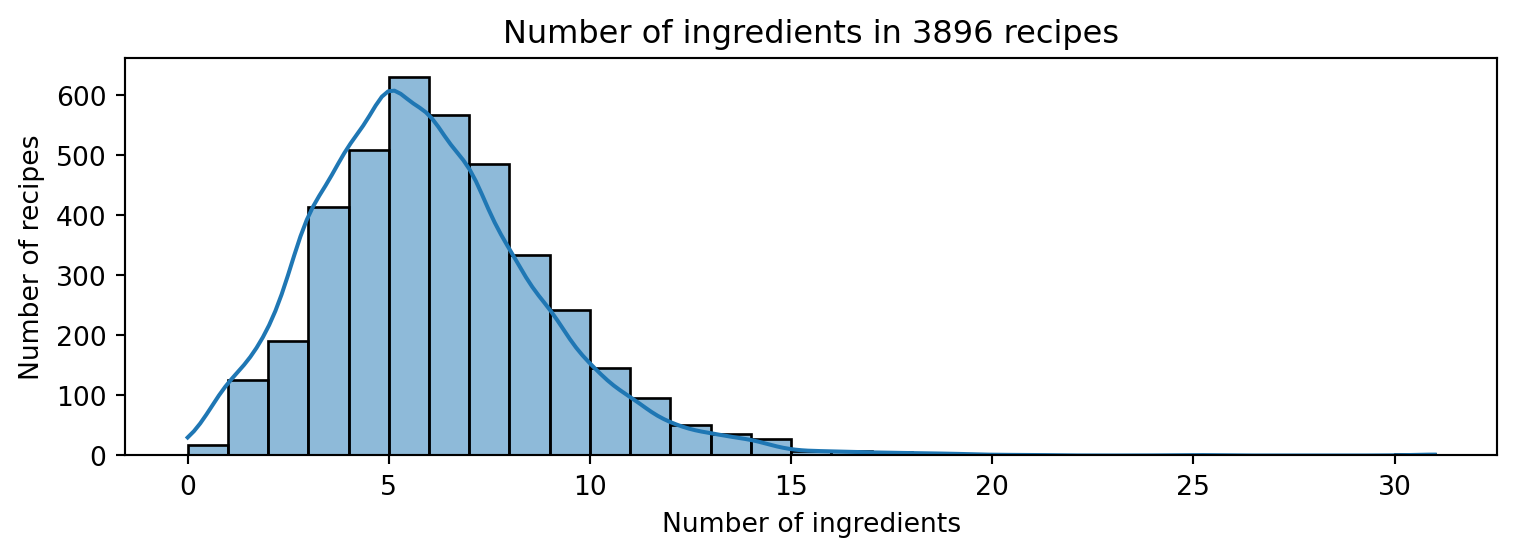

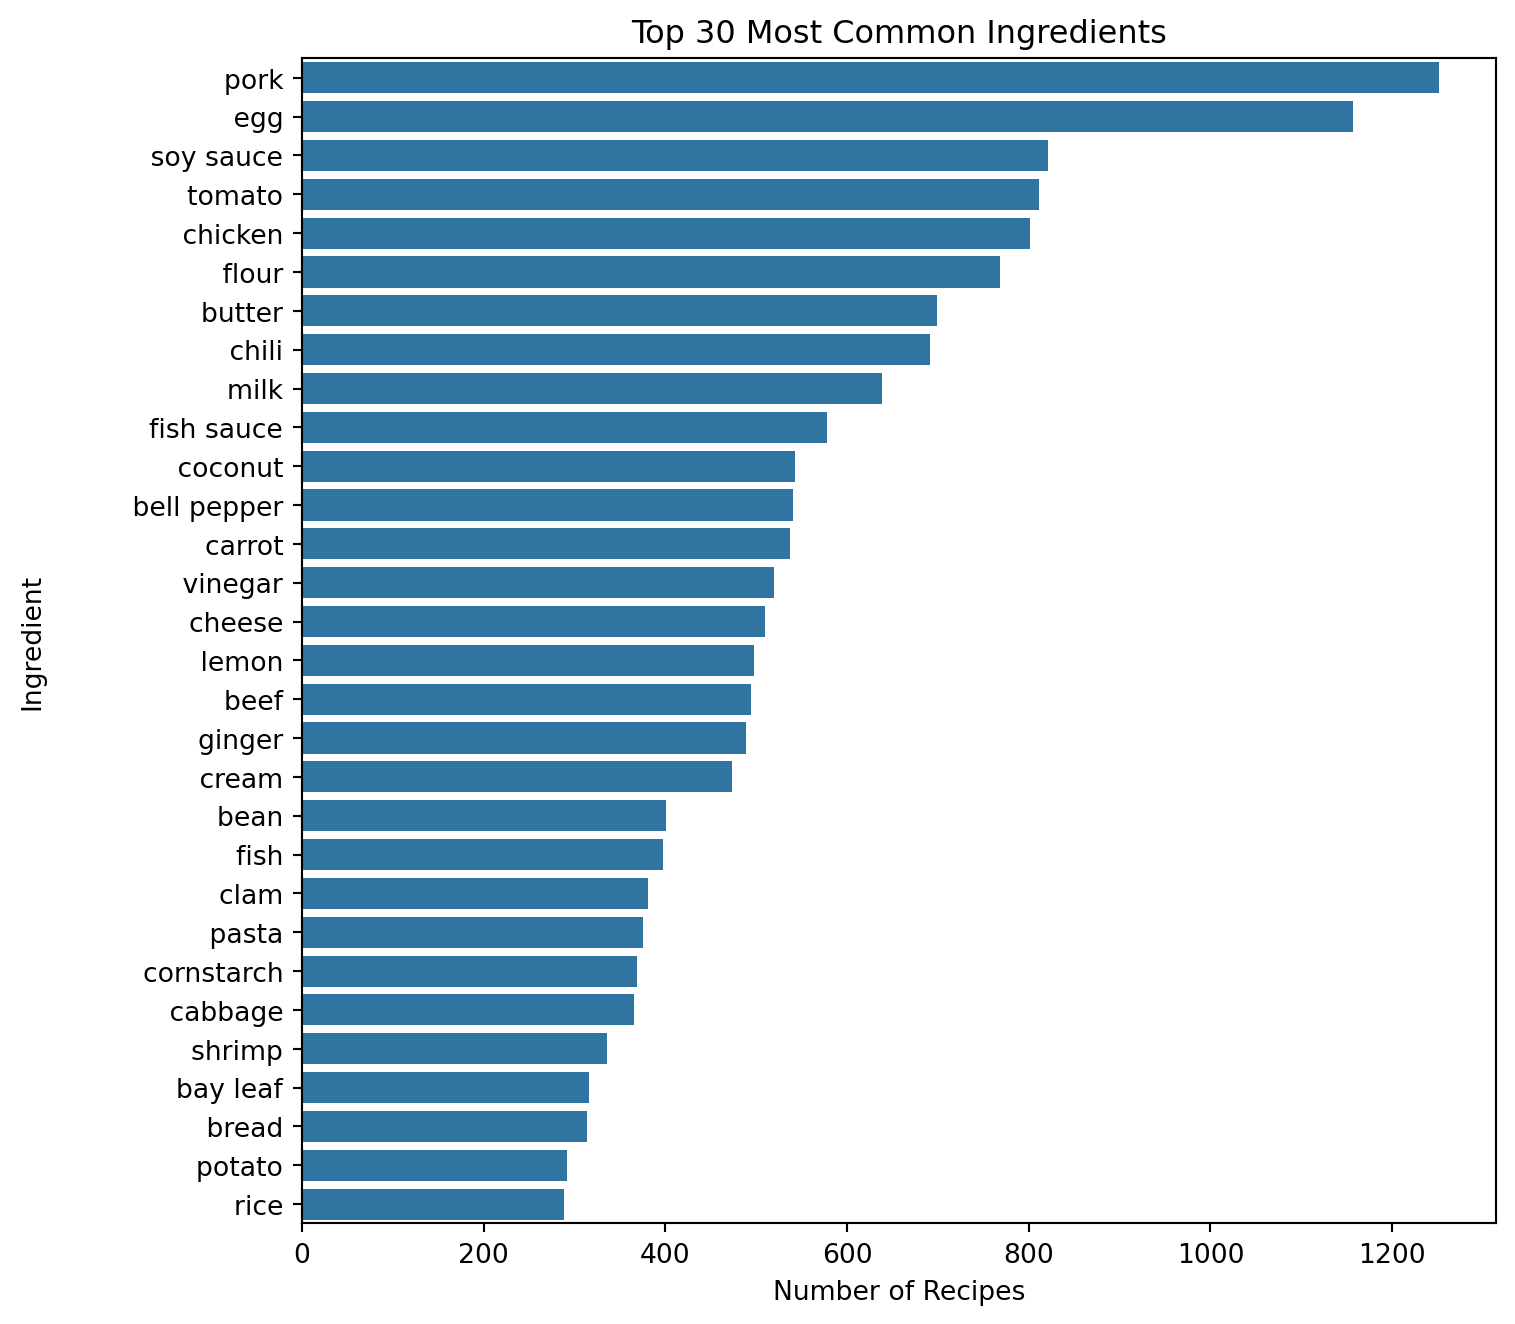

In [26]:
plot_ingredient_count_distribution(recipe_df.filtered_unique)
plot_common_ingredients(recipe_df.filtered_unique)

## Data Transformation


### Convert DataFrame to one-hot encoded format


In [27]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
one_hot = mlb.fit_transform(recipe_df.filtered_unique)
one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)

one_hot_df.head()

,alcohol,anise,annatto,apple,asparagus,avocado,baking soda,banana,barbecue sauce,basil,...,tofu,tomato,turnip,vanilla,vegetable,vegetable broth,vinegar,wrapper,yam,yeast
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
one_hot_df.to_csv(
    "data/one_hot_encoded_recipes.csv",
    index=False,
)

## Association Analysis


In [29]:
import pandas as pd

one_hot_df = pd.read_csv("data/one_hot_encoded_recipes.csv")
one_hot_df = one_hot_df.astype(bool)
one_hot_df.head()

,alcohol,anise,annatto,apple,asparagus,avocado,baking soda,banana,barbecue sauce,basil,...,tofu,tomato,turnip,vanilla,vegetable,vegetable broth,vinegar,wrapper,yam,yeast
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Find frequent itemsets


In [30]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(
    one_hot_df,
    min_support=0.01, #  Lower this value to get more frequent itemsets
    use_colnames=True,
)

frequent_itemsets.head()

,support,itemsets
0,0.047998,(alcohol)
1,0.013860,(anise)
2,0.021561,(annatto)
3,0.060062,(baking soda)
4,0.044661,(banana)


In [31]:
len(frequent_itemsets)

672

### Generate association rules


In [32]:
from mlxtend.frequent_patterns import association_rules

rules_df = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.5,
)

cols = ["antecedents", "consequents", "support", "confidence"]
rules_df[cols].head()

,antecedents,consequents,support,confidence
0,(anise),(soy sauce),0.010267,0.740741
1,(annatto),(fish sauce),0.011294,0.523810
2,(baking soda),(butter),0.030031,0.500000
3,(baking soda),(egg),0.052875,0.880342
4,(baking soda),(flour),0.051848,0.863248


In [33]:
len(rules_df)

543

In [34]:
rules_df["antecedents"] = rules_df["antecedents"].apply(list)
rules_df["consequents"] = rules_df["consequents"].apply(list)

rules_df.to_csv(
    "data/association_rules.csv",
    index=False,
    columns=["antecedents", "consequents"],
)

### Visualize

#### Prepare Data

In [35]:
rules_df["antecedents"] = rules_df["antecedents"].apply(
    lambda x: ", ".join(list(x))
)
rules_df["consequents"] = rules_df["consequents"].apply(
    lambda x: ", ".join(list(x))
)

edges = [
    (ant, cons)
    for ant, cons in zip(rules_df["antecedents"], rules_df["consequents"])
]

In [36]:
len(edges)

543

In [37]:
edges[:10]

[('anise', 'soy sauce'),
 ('annatto', 'fish sauce'),
 ('baking soda', 'butter'),
 ('baking soda', 'egg'),
 ('baking soda', 'flour'),
 ('vanilla', 'baking soda'),
 ('baking soda', 'vanilla'),
 ('bay leaf', 'pork'),
 ('bay leaf', 'vinegar'),
 ('okra', 'bean')]

#### Create Graph

In [38]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from(edges)

#### Generate Node and Edge Information on Hover

In [39]:
pos = nx.spring_layout(G)  # Node positions
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]
node_adjacencies = []
node_text = []
for node in G.nodes():
    adjacents = G.adj[node]
    connections = [f"{node} → {neighbor}" for neighbor in adjacents]
    node_adjacencies.append(len(adjacents))
    node_text.append("Connections:<br>" + "<br>".join(connections))

#### Create Edge and Node Traces

In [40]:
import plotly.graph_objects as go

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color="#888"),
    hoverinfo="none",
    mode="lines",
)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers",
    hoverinfo="text",
    text=node_text,
    marker=dict(
        showscale=True,
        colorscale="YlGnBu",
        reversescale=True,
        color=node_adjacencies,
        size=10,
        colorbar=dict(
            thickness=15,
            title="Node Connections",
            xanchor="left",
            titleside="right",
        ),
        line_width=1,
    ),
)

#### Plot the Graph

In [41]:
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        showlegend=False,
        hovermode="closest",
        margin=dict(b=20, l=20, r=20, t=20),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    ),
)
fig.show()